In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import expit, logit
import numpy as np
from tqdm import tqdm
import numpyro
import numpyro.distributions as dist
import src.Aux_functions as aux
from itertools import combinations
import matplotlib.pyplot as plt 
import time 
import blackjax 
from typing import NamedTuple, Any

print("JAX version: {}".format(jax.__version__))
print("blackjax version: {}".format(blackjax.__version__))
print("NumPyro version: {}".format(numpyro.__version__))



JAX version: 0.4.28
blackjax version: 1.2.0
NumPyro version: 0.15.2


In [2]:
key = random.PRNGKey(0)
key = random.split(key, 1)[0]

RANDOM_SEED = 7
rng = np.random.default_rng(RANDOM_SEED)

# Generate some data
n = 500
triu_dim = n*(n-1)//2

# x = random.normal(key, shape=(n,))*3
x = jnp.array(rng.normal(loc=0, scale=1, size=n), dtype=jnp.float32)
# x = jnp.array(rng.normal(loc=0, scale=3, size=n), dtype=jnp.float32)
# x2 = random.binomial(key, n=1, p=0.1, shape=(n,))
x2 = jnp.array(rng.binomial(n=1, p=.1, size=n), dtype=jnp.float32)
idx_pairs = list(combinations(range(len(x)), 2))
x_diff = jnp.array([abs(x[i] - x[j]) for i, j in idx_pairs])
x2_or = jnp.array([1 if (x2[i] + x2[j] == 1) else 0 for i, j in idx_pairs])


print(x.shape, x2.shape, x_diff.shape, x2_or.shape)

# U = jnp.array(rng.normal(loc=0, scale=1, size=(n, 2)))

# def latent_to_norm_of_diff(U):
#     idx = jnp.triu_indices(n=U.shape[0], k=1)
#     U_diff = U[idx[0]] - U[idx[1]]
#     # print(U_diff.shape)
#     return jnp.linalg.norm(U_diff, axis=1)

# U_norm = latent_to_norm_of_diff(U)
# print(U_norm.shape)

# Network data

df_edges = jnp.transpose(jnp.stack([jnp.ones(triu_dim), x_diff, x2_or]))
theta = jnp.array([-2.5, -0.25, 1])
# theta = jnp.array([-2.5, -0.5, 2])
# theta = jnp.array([-2.5, -0.5, 1.5])
# gamma = jnp.array([1.1, 0.2, -1, 1])
gamma = jnp.array([logit(0.7), logit(0.2), 0.1, -0.5])
# gamma = jnp.array([logit(.85), logit(.15)])

# triu_star_probs = expit(jnp.dot(df_edges, theta) - U_norm)
triu_star_probs = expit(jnp.dot(df_edges, theta))
# triu_star = random.binomial(key, n=1, p=triu_star_probs, shape=(triu_dim,))
triu_star = jnp.array(rng.binomial(n=1, p=triu_star_probs, size=triu_dim), dtype=jnp.float32)

triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * jnp.dot(df_edges, gamma[1:]))
# triu_obs_probs = expit((triu_star * gamma[0]) + (1 - triu_star) * (gamma[1] + jnp.dot(df_edges, gamma[2:])))
# triu_obs_probs = expit(triu_star*gamma[0] + (1 - triu_star)*gamma[1])
# triu_obs = random.binomial(key, n=1, p=triu_obs_probs, shape=(triu_dim,))
triu_obs = jnp.array(rng.binomial(n=1, p=triu_obs_probs, size=triu_dim), dtype = jnp.float32)

print(triu_star.shape, triu_obs.shape)

# Outcome data

@jax.jit
def degree_centrality(adj_matrix):
    """
    Compute normalized degree centrality for all nodes in the network using JAX.
    
    Parameters:
    adj_matrix (jnp.ndarray): Square adjacency matrix (n x n)
    
    Returns:
    jnp.ndarray: Vector of normalized degree centralities
    """
    # Compute degrees (sum of rows for undirected graph)
    degrees = jnp.sum(adj_matrix, axis=1)
    
    # Normalize by maximum possible degree (n-1)
    n = adj_matrix.shape[0]
    return degrees / (n - 1)
    
@jax.jit
def compute_exposures(triu_star, Z):
    mat_star = aux.Triu_to_mat(triu_star)
    # eigen_cen = aux.eigen_centrality(mat_star)
    deg_cen = degree_centrality(mat_star)
    return aux.zeigen_value(Z, deg_cen, mat_star)

mat_star = aux.Triu_to_mat(triu_star)
# Z = random.binomial(key, n=1, p=0.5, shape=(n,))
Z = jnp.array(rng.binomial(n=1, p=0.5, size=n), dtype=jnp.float32)
# exposures = jnp.dot(mat_star, Z)
exposures = compute_exposures(triu_star, Z)

# eta = jnp.array([-1, 3, -0.25, 1, 3])
eta = jnp.array([-1, 3, -0.25, 3])
# df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, x2, exposures]))
df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, x, exposures]))

mean_y = jnp.dot(df_nodes, eta)
sig_y = 1

# Y = random.normal(key, shape=(n,))*sig_y + mean_y
Y =  jnp.array(mean_y + rng.normal(loc=0, scale=sig_y, size=n), dtype=jnp.float32)

print(Y.shape)



(500,) (500,) (124750,) (124750,)
(124750,) (124750,)
(500,)


mean exposure:  1.5582967 
 std exposure:  0.5065012 
 median exposure:  1.481964


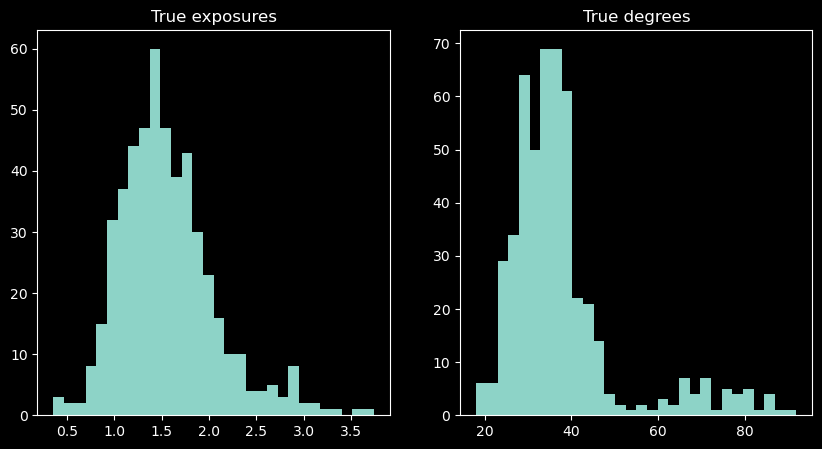

In [3]:
# panel of two plots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# plot 1
axs[0].hist(exposures, bins=30)
axs[0].set_title("True exposures")

# plot 2
axs[1].hist(jnp.sum(mat_star, axis=1), bins=30)
axs[1].set_title("True degrees")

print("mean exposure: ", jnp.mean(exposures), "\n",
      "std exposure: ", jnp.std(exposures), "\n",
      "median exposure: ", jnp.median(exposures))

Text(0.5, 1.0, 'True vs Observed exposures')

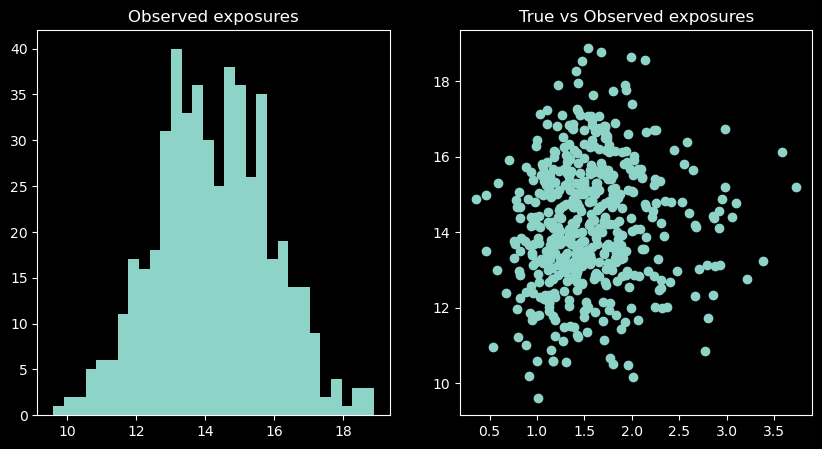

In [3]:
expos_obs = compute_exposures(triu_obs, Z)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(expos_obs, bins=30)
axs[0].set_title("Observed exposures")

axs[1].scatter(exposures, expos_obs)
axs[1].set_title("True vs Observed exposures")

# create y~x line
# x_line = np.linspace(min(exposures), max(exposures), 100)
# y_line = x_line
# plt.plot(x_line, y_line, color='red')

cor Y~exposures:  0.6483329 
 cor Y~observed exposures:  -0.025057185


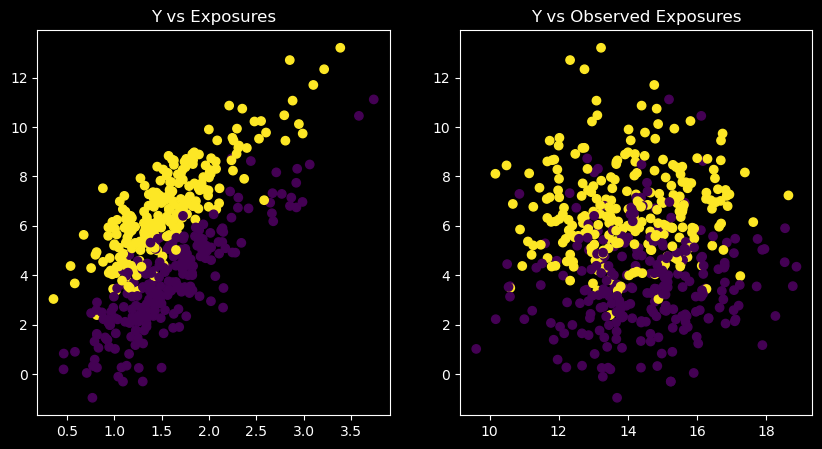

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))


axs[0].scatter(exposures, Y, c=Z)
axs[0].set_title("Y vs Exposures")

axs[1].scatter(expos_obs, Y, c=Z)
axs[1].set_title("Y vs Observed Exposures")

print("cor Y~exposures: ", jnp.corrcoef(Y, exposures)[0, 1], "\n",
        "cor Y~observed exposures: ", jnp.corrcoef(Y, expos_obs)[0, 1])

In [6]:
@jax.jit
def A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma):
    logits_a_star = jnp.dot(df_edges, theta)
    # a_star_log_likelihood = triu_star * (-jnp.log1p(jnp.exp(-logits_a_star))) + (1 - triu_star) * (-jnp.log1p(jnp.exp(logits_a_star)))
    a_star_log_likelihood = triu_star*logits_a_star - jnp.log1p(jnp.exp(logits_a_star))

    logits_a_obs = (triu_star * gamma[0]) + (1 - triu_star) * jnp.dot(df_edges, gamma[1:])
    # logits_a_obs = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    # a_obs_log_likelihood = triu_obs * (-jnp.log1p(jnp.exp(-logits_a_obs))) + (1 - triu_obs) * (-jnp.log1p(jnp.exp(logits_a_obs)))
    a_obs_log_likelihood = triu_obs*logits_a_obs - jnp.log1p(jnp.exp(logits_a_obs))

    log_prob = a_star_log_likelihood + a_obs_log_likelihood 
    log_prob_sum = jnp.sum(log_prob)

    return log_prob_sum, log_prob


@jax.jit
def A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta, sigma):
    log_prob_sum_n, log_prob_n = A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma)
    # curr_a_star = aux.Triu_to_mat(triu_star)
    # exposures = jnp.dot(curr_a_star, Z)
    exposures = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, exposures]))
    mean_y = jnp.dot(df_nodes, eta)
    y_log_likelihood = - 0.5 * jnp.sum((Y - mean_y)**2) / sigma**2 - n * jnp.log(sigma)

    return log_prob_sum_n + y_log_likelihood, log_prob_n + y_log_likelihood


In [7]:
print(A_star_cond_log_post(triu_star, triu_obs, df_edges, theta, gamma))
print(A_star_cond_log_post_with_Y(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta, sig_y))

(Array(-96258.05, dtype=float32), Array([-0.30260247, -0.30254233, -0.30524105, ..., -0.31642962,
       -0.34252357, -0.2952215 ], dtype=float32))
(Array(-96510.04, dtype=float32), Array([-252.29424, -252.29417, -252.29688, ..., -252.30807, -252.33417,
       -252.28687], dtype=float32))


(124750,) (124750,)
-96510.04 
 [-3.1286452 -3.2992895 -3.2163444 -3.2099972 -0.8323662 -3.3014781
 -3.2501957 -0.9402919 -3.2548623]


Text(0.5, 1.0, 'Scores')

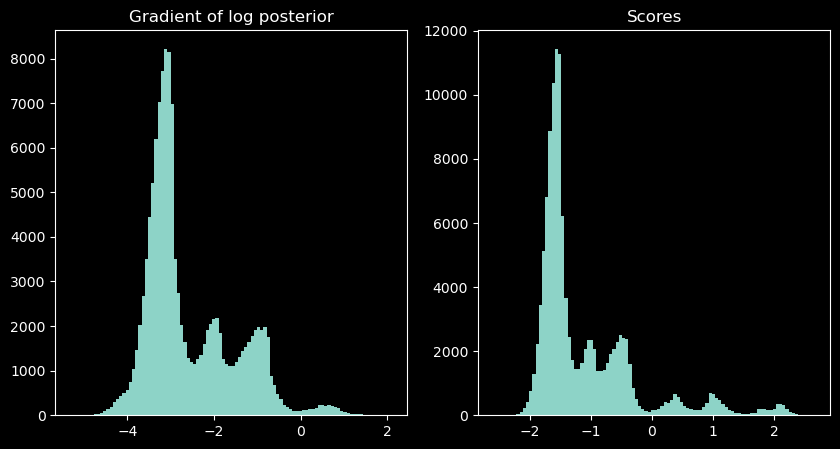

In [8]:
# val_grad_fn = jax.value_and_grad(A_star_cond_log_post, argnums=0, has_aux=True) 
val_grad_fn = jax.value_and_grad(A_star_cond_log_post_with_Y, argnums=0, has_aux=True) 

# (sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma)
(sum_logprob, log_prob), gradient = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, x, Z, eta, sig_y)
print(log_prob.shape, gradient.shape)
print(sum_logprob, "\n", gradient[1:10])

fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# create histogram of gradient

axs[0].hist(gradient, bins=100)
axs[0].set_title("Gradient of log posterior")

# create histogram of scores
score_grad = -(2*triu_star-1)*gradient/2
axs[1].hist(score_grad, bins=100)
axs[1].set_title("Scores")


In [9]:

def weighted_sample_and_logprobs(key, scores, M):
    # Get samples using Gumbel-max trick
    gumbel_noise = random.gumbel(key, shape=scores.shape)
    perturbed = scores + gumbel_noise
    selected_indices = jnp.argsort(-perturbed)[:M]

     # Compute log probabilities
    # log_probs = jax.nn.log_softmax(scores)
    log_probs = jax.nn.log_softmax(scores)
    # print("min log prob: ", jnp.min(log_probs), "max log prob: ", jnp.max(log_probs), "\n",
    #       "std log prob: ", jnp.std(log_probs), "mean log prob: ", jnp.mean(log_probs), "\n",
    #       "median log prob: ", jnp.median(log_probs))
    selected_log_probs = log_probs[selected_indices]
    # print("select", selected_log_probs)

    return selected_indices, selected_log_probs.sum()

@jax.jit
def propsal_logprobs(idx, scores):
    log_probs = jax.nn.log_softmax(scores)
    return log_probs[idx].sum()



In [10]:
# qq = 3 - 1
al = -.9
qq = 3*jnp.exp(al)
qq2 = 2*jnp.exp(al)

# jnp.exp(qq) / (1 + jnp.exp(qq))
logsm = jax.nn.log_softmax(jnp.array([qq, qq2]))
print(qq/qq2)
print(jnp.exp(logsm[0]/ logsm[1]))


1.4999999
1.7447448


In [11]:
@jax.jit
def annealed_A_star_cond_logpost(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta, sig_y,
                                 anneal=1.0):
    # p(A*|X,\theta)
    logits_a_star = jnp.dot(df_edges, theta)
    # a_star_log_likelihood = triu_star * (-jnp.log1p(jnp.exp(-logits_a_star))) + (1 - triu_star) * (-jnp.log1p(jnp.exp(logits_a_star)))
    a_star_log_likelihood = triu_star*logits_a_star - jnp.log1p(jnp.exp(logits_a_star))

    # p(A|A*,X,\gamma)
    logits_a_obs = (triu_star * gamma[0]) + (1 - triu_star) * jnp.dot(df_edges, gamma[1:])
    # logits_a_obs = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    # a_obs_log_likelihood = triu_obs * (-jnp.log1p(jnp.exp(-logits_a_obs))) + (1 - triu_obs) * (-jnp.log1p(jnp.exp(logits_a_obs)))
    a_obs_log_likelihood = triu_obs*logits_a_obs - jnp.log1p(jnp.exp(logits_a_obs))

    # p(Y|A*,X,Z,\eta,\sig_y)
    exposures = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, exposures]))
    mean_y = jnp.dot(df_nodes, eta)
    y_log_likelihood = - 0.5 * jnp.sum((Y - mean_y)**2) / sig_y**2 - n * jnp.log(sig_y)

    # A_star_log_post = jnp.sum(a_star_log_likelihood) 
    # annealed_log_post = (1- anneal)*(jnp.sum(a_obs_log_likelihood) + jnp.sum(y_log_likelihood))
    
    # return A_star_log_post + annealed_log_post

    annealed_log_post = (1-anneal)*(jnp.sum(a_star_log_likelihood) + jnp.sum(a_obs_log_likelihood))
    return annealed_log_post + jnp.sum(y_log_likelihood)

annealead_val_grad_fn = jax.value_and_grad(annealed_A_star_cond_logpost)




In [12]:

TRIU_LEN = triu_star.shape[0]
BATCH_PROP = .0005
BATCH_LEN = int(TRIU_LEN * BATCH_PROP)
# BATCH_LEN = 500
# BATCH_LEN = 5
# BATCH_LEN = 2*jnp.ceil(jnp.log(n)).astype(int)
# BATCH_LEN = 4*jnp.ceil(jnp.log(TRIU_LEN)).astype(int)
# BATCH_LEN = jnp.ceil(jnp.log(TRIU_LEN)/2).astype(int)
print(BATCH_LEN)


#TODO: update return to 'state, info' namedtuples,
#  where state contatin the current triu_star values and info logpost and acc_rate

class IPState(NamedTuple):
    positions: Any
    logdensity: Any
    logdensity_grad: Any
    scores: Any
    # logdensity: float
    # logdensity_grad: float
    # scores: float

class IPInfo(NamedTuple):
    acceptance_rate: float
    is_accepted: bool

@jax.jit
def GWG_kernel(rng_key, state, triu_obs, df_edges, theta, gamma,
                      Y, X, Z, eta, sig_y, step_size = 1.0, anneal=1.0, 
                      valgrad_fn = annealead_val_grad_fn):

    key1, key2, key3 = random.split(rng_key, 3)

    # uniform_scores = random.uniform(key3, shape=(state.scores.shape[0],))

    # (f_baseline,_), baseline_grad = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta)
    # baseline_scores = (-(2*triu_star-1)*baseline_grad)/2

    # idx, forward_logprob = weighted_sample_and_logprobs(key1, cur_scores*jnp.exp(-alpha), BATCH_LEN)
    # idx, forward_logprob = weighted_sample_and_logprobs(key1, baseline_scores*jnp.exp(-step_size), BATCH_LEN)
    # idx, forward_logprob = weighted_sample_and_logprobs(key1, baseline_scores - step_size, BATCH_LEN)
    
    # forward_annealed_scores = anneal * uniform_scores + (1 - anneal) * (state.scores-step_size)
    
    idx, forward_logprob = weighted_sample_and_logprobs(key1, state.scores - step_size, BATCH_LEN)
    # idx, forward_logprob = weighted_sample_and_logprobs(key1, forward_annealed_scores, BATCH_LEN)

    # new_triu_star = triu_star.at[idx].set(1 - triu_star[idx])
    new_triu_star = state.positions.at[idx].set(1 - state.positions[idx])

    # backward proposal
    f_proposed, backward_grad = valgrad_fn(new_triu_star, triu_obs, df_edges,
                                        theta, gamma, Y, X, Z, eta, sig_y, anneal)
    
    # (f_proposed,_), backward_grad = val_grad_fn(new_triu_star, triu_obs, df_edges,
    #                                     theta, gamma, Y, X, Z, eta, sig_y)
    backward_scores = (-(2*new_triu_star-1)*backward_grad)/2
    # backward_logprob = propsal_logprobs(idx, backward_scores*jnp.exp(-step_size))
    backward_logprob = propsal_logprobs(idx, backward_scores - step_size)


    # forward_annealed_logprob = (1-anneal) * forward_logprob
    # backward_annealed_logprob = (1-anneal) * backward_logprob

    # get acceptance ratio (exp of log probs)
    # acceptance_ratio = jnp.clip(jnp.exp(f_proposed - state.logdensity +
                                        #  backward_annealed_logprob - forward_annealed_logprob),
                                # a_max=1)
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - state.logdensity + backward_logprob - forward_logprob),
                                a_max=1)
    # accept or reject
    accept = random.uniform(key2) <= acceptance_ratio

    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, state.positions)
    new_logpost = jax.lax.select(accept, f_proposed, state.logdensity)
    new_grad = jax.lax.select(accept, backward_grad, state.logdensity_grad)
    new_scores = jax.lax.select(accept, backward_scores, state.scores)
    # new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    # new_logpost = jax.lax.select(accept, f_proposed, f_baseline)
    # new_grad = jax.lax.select(accept, backward_grad, baseline_grad)
    # new_scores = jax.lax.select(accept, backward_scores, baseline_scores)

    # return new_triu_star, acceptance_ratio
    # return new_triu_star, acceptance_ratio, new_scores, new_logpost
    state = IPState(new_triu_star, new_logpost, new_grad, new_scores)
    info = IPInfo(acceptance_ratio, accept)
    # info = IPInfo(acceptance_ratio, accept)
    # return new_triu_star, acceptance_ratio, new_logpost
    return state, info
    
     
@jax.jit
def DMALA_kernel(rng_key, triu_star, triu_obs, df_edges, theta, gamma,
                 Y, X, Z, eta, sig_y, step_size = 1.0, eps=1e-8):
    key1, key2, key3 = random.split(rng_key, 3)
    # sample idx to propose edge flip
    idx = random.choice(key1, TRIU_LEN, (BATCH_LEN,), replace=False)

    # compute baseline log-posterior and gradient
    (f_baseline,_), baseline_grad = val_grad_fn(triu_star, triu_obs, df_edges, theta, gamma,
                                                 Y, X, Z, eta, sig_y)
    baseline_scores = (-(2*triu_star-1)*baseline_grad)/2
    baseline_scores = baseline_scores[idx]
    baseline_std_scores = jnp.exp(baseline_scores - step_size)
    baseline_std_scores = jnp.clip(baseline_std_scores, -20, 20)
    
    # flip probablities
    baseline_flip_probs = baseline_std_scores / (1 + baseline_std_scores)

    # sample flip indicator I
    flip_indicator = random.uniform(key2, shape=(BATCH_LEN,)) < baseline_flip_probs
    
    # compute combined forward proposal q(\tilde{A}*_t|A*_t)
    forward_probs = baseline_flip_probs * flip_indicator + (1 - baseline_flip_probs) * (1 - flip_indicator)
    forward_proposal = jnp.sum(jnp.log(forward_probs + eps)) 

    # new proposed triu_star (after deciding which edges to flip)
    # it is proposed_triu_star with flipped edges only where flip_indicator is True
    new_triu_star = triu_star.at[idx].set(flip_indicator * (1 - triu_star[idx]) +
                                              (1 - flip_indicator) * triu_star[idx])

    # compute log-posterior and gradient for proposed triu_star
    (f_proposed,_), proposed_grad = val_grad_fn(new_triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta)
    proposed_scores = (-(2*new_triu_star-1)*proposed_grad)/2
    proposed_scores = proposed_scores[idx]
    proposed_std_scores = jnp.exp(proposed_scores - step_size)
    proposed_std_scores = jnp.clip(proposed_std_scores, -20, 20)
    backward_probs = proposed_std_scores / (1 + proposed_std_scores)

    # compute backward proposal q(A*_t|\tilde{A}*_t)
    backward_propsal = jnp.sum(jnp.log(backward_probs + eps))

    # compute acceptance ratio
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - f_baseline + backward_propsal - forward_proposal),
                                a_max=1)
    
    # accept or reject
    accept = random.uniform(key3) <= acceptance_ratio

    # update triu_star
    new_triu_star = jax.lax.select(accept, new_triu_star, triu_star)
    new_logpost = jax.lax.select(accept, f_proposed, f_baseline)
    new_grad = jax.lax.select(accept, proposed_grad, baseline_grad)
    state = IPState(new_triu_star, new_logpost, new_grad)
    info = IPInfo(acceptance_ratio, accept)
    
    return state, info
    



62


In [13]:
al = 0.1
lal = jnp.log(al)
adj = 300*0.01*(1-0.574)
al2 = lal + adj 
e_al = jnp.exp(al2)

print(al, lal, adj, al2, e_al)


0.1 -2.3025851 1.278 -1.0245851 0.35894537


In [14]:
@jax.jit
def adaptive_step_size(alpha, acceptance_rate, target_rate=0.574, adapt_rate=0.01):
    """
    Updates step size alpha based on the observed acceptance rate.
    """
    # adjustment = gamma * (target_rate - acceptance_rate)
    # return alpha + adjustment
    log_alpha = jnp.log(alpha)
    log_alpha += adapt_rate * (acceptance_rate - target_rate)
    return jnp.exp(log_alpha)

In [15]:
# make noisy triu_star
key,_  = random.split(key)
triu_star_noisy = (triu_star * random.binomial(key, n=1, p=0.9, shape=(triu_dim,)) +
                   (1-triu_star) * random.binomial(key, n=1, p=0.1, shape=(triu_dim,)))

eta_n = eta 
eta_n = eta_n.at[3].set(eta_n[3] - 2.0)
theta_n = theta
theta_n = theta_n.at[1].set(theta_n[1] - 1.5)
# theta_n[1] = theta_n[1] - 1.5
# test A_star update

# alpha = jnp.log(2.0)
step_size = 1.0
n_iter = 1000
# n_iter = 3000
# new_triu_star = triu_star_noisy
new_triu_star = triu_obs
exposures_lst = [compute_exposures(new_triu_star, Z)]
log_post = []
acceptance_rates = []
# acceptance_rates = jnp.zeros
ADAPT_WINDOW = 100


# start = time.time()
# for i in tqdm(range(int(n_iter))):
#     key, _ = random.split(key)
  
#     new_triu_star, acc, logpost = triu_star_update(key, new_triu_star, triu_obs, df_edges,
#                                       theta, gamma, Y, x, Z, eta, step_size)
#     # new_triu_star, acc, cur_scores, cur_logpost = triu_star_update(new_triu_star,
#     #                                                                cur_scores, cur_logpost,
#     #                                                                 triu_obs, df_edges,
#     #                                   theta_n, gamma, Y, x, Z, eta_n, key, alpha=alpha)
#     exposures_lst.append(compute_exposures(new_triu_star, Z))
#     acceptance_rates.append(acc)
#     log_post.append(logpost)
    
#     if i % ADAPT_WINDOW == 0:
#         # mean_acceptance_rate = jnp.mean(jnp.array(acceptance_rates[-ADAPT_WINDOW:]))
#         mean_acceptance_rate = np.mean(acceptance_rates[-ADAPT_WINDOW:])
#         alpha = adaptive_step_size(alpha, mean_acceptance_rate)
#         print(f"Iteration {i}, New Alpha: {alpha}, Acceptance Rate: {mean_acceptance_rate}")

#         # eta_n[-1] = eta_n[-1] + 0.04
#         # eta_n = eta_n.at[3].set(eta_n[3] + 0.02)
#         # theta_n[1] = theta_n[1] + 0.03
#         # theta_n = theta_n.at[1].set(theta_n[1] + 0.015)

# print("for loop total time: ", time.time() - start)

    


In [16]:
start = time.time()

def scan_body(carry, i):
    # Unpack carry
    # key, new_triu_star, step_size, window_acceptances = carry
    # key, cur_state, step_size, window_acceptances = carry
    key, cur_state, step_size, window_acceptances = carry
    
    # Original loop body
    key, subkey = random.split(key)
    state, info = GWG_kernel(
        subkey, cur_state, triu_obs, df_edges,
        theta, gamma, Y, x, Z, eta, sig_y, step_size, .5
    )
    # state, info = triu_star_kernel(
    #     subkey, new_triu_star, triu_obs, df_edges,
    #     theta, gamma, Y, x, Z, eta, step_size
    # )

    
    # Handle adaptive step size
    window_acceptances = window_acceptances.at[i % ADAPT_WINDOW].set(info.acceptance_rate)
    new_step_size = jax.lax.cond(
        i % ADAPT_WINDOW == ADAPT_WINDOW - 1,
        lambda t: adaptive_step_size(t[0], jnp.mean(t[1])),
        lambda t: t[0],
        (step_size, window_acceptances)
    )
    
    # Return carry and outputs
    # new_carry = (key, new_triu_star, new_step_size, window_acceptances)
    new_carry = (key, state, new_step_size, window_acceptances)
    outputs = (state.positions, info.acceptance_rate, state.logdensity, new_step_size)
    # outputs = (new_triu_star, acc, logpost, new_step_size)
    # outputs = (exposures_s, acc, logpost, new_alpha)
    
    return new_carry, outputs

# Initialize carry values
ADAPT_WINDOW = 10
window_acceptances = jnp.zeros(ADAPT_WINDOW)

# get init state
triu_star_noisy = triu_obs
# (f_init,_), grad_init = val_grad_fn(new_triu_star, triu_obs, df_edges,
#                                     theta, gamma, Y, x, Z, eta, sig_y)
f_init, grad_init = annealead_val_grad_fn(triu_star_noisy, triu_obs, df_edges,
                                    theta, gamma, Y, x, Z, eta, sig_y, 0.5)
init_scores = (-(2*triu_star_noisy-1)*grad_init)/2
init_state = IPState(triu_star_noisy, f_init, grad_init, init_scores)

# init_carry = (key, init_state, 1.0, window_acceptances)
init_carry = (key, init_state, 1e-1, window_acceptances)
# init_carry = (key, triu_star_noisy, 1.0, window_acceptances)

# Run scan
final_carry, (new_triu_star, acceptance_rates_sc, log_post_sc, alphas_sc) = jax.lax.scan(
    scan_body,
    init_carry,
    # jnp.arange(n_iter)
    jnp.arange(1000)
)


print("scan total time: ", time.time() - start)
# 

scan total time:  65.37807893753052


In [17]:
print("logpost shape", log_post_sc.shape, "\n",
      # "exposures shape", exposures_sc.shape, "\n",
      "post triu_star shape", new_triu_star.shape, "\n",
      "acceptance rates shape", acceptance_rates_sc.shape, "\n",
      "alpha shape", alphas_sc.shape, "\n",
      "new_triu_star shape", final_carry[1].positions.shape)
 
# print("logpost shape", log_post_dm.shape, "\n",
#       # "exposures shape", exposures_sc.shape, "\n",
#       "post triu_star shape", new_triu_star_dm.shape, "\n",
#       "acceptance rates shape", acceptance_rates_dm.shape, "\n",
#       "alpha shape", alphas_dm.shape, "\n",
#       "new_triu_star shape", final_carry_dmala[1].shape)

logpost shape (1000,) 
 post triu_star shape (1000, 124750) 
 acceptance rates shape (1000,) 
 alpha shape (1000,) 
 new_triu_star shape (124750,)


In [18]:
vmap_compute_exposures = jax.vmap(compute_exposures, in_axes=(0, None))
exposures_sc = vmap_compute_exposures(new_triu_star, Z)
# exposures_dmala = vmap_compute_exposures(new_triu_star_dm, Z)
print(exposures_sc.shape)
# print(exposures_sc.shape, exposures_dmala.shape)

(1000, 500)


mean acc rate :  nan


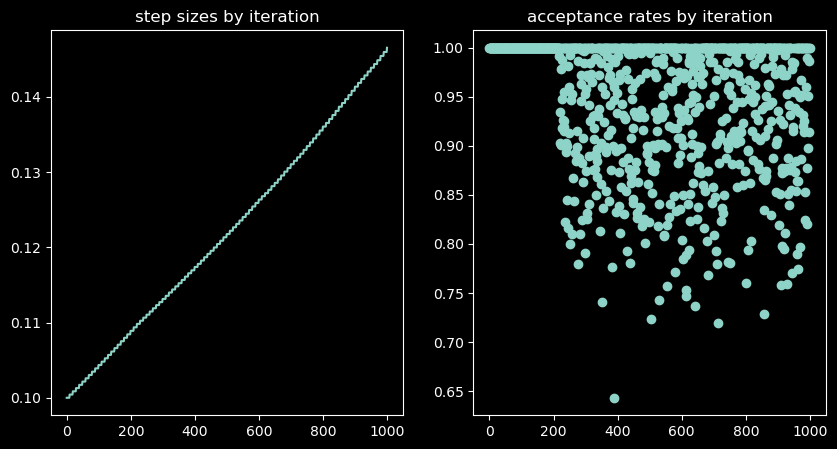

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(alphas_sc)
axs[0].set_title("step sizes by iteration")

# axs[1].scatter(jnp.arange(1500),acceptance_rates_sc)
axs[1].scatter(jnp.arange(1000),acceptance_rates_sc)
axs[1].set_title("acceptance rates by iteration")

print("mean acc rate : ", jnp.mean(acceptance_rates_sc[1000:]))

True expos mean: 1.5582967 
 Posterior expos mean: 1.9892105


Text(0.5, 1.0, '-Log-posterior over iterations')

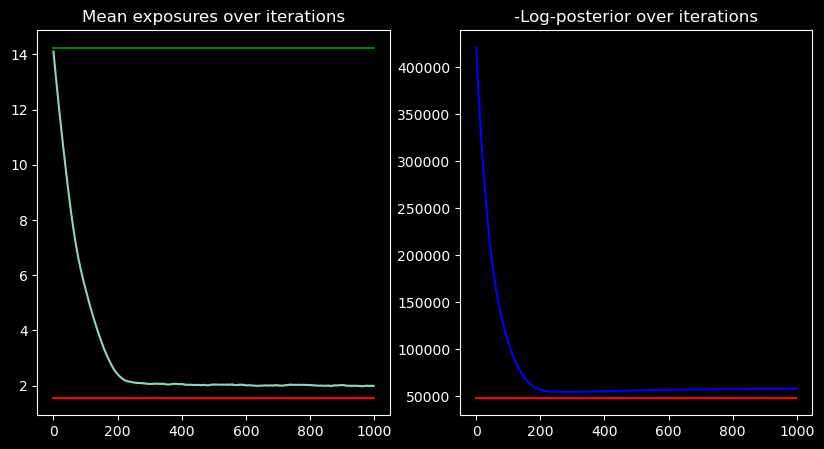

In [20]:

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# expos_arr = jnp.array(exposures_lst)[1:]
expos_arr = exposures_sc
print("True expos mean:", exposures.mean(), "\n",
      "Posterior expos mean:", expos_arr.mean(axis=1)[-1])

true_logpost, true_grad = annealead_val_grad_fn(triu_star, triu_obs, df_edges,
                                            theta, gamma, Y, x, Z, eta, sig_y, .5)

# (true_logpost,_), true_grad = val_grad_fn(triu_star, triu_obs, df_edges,
#                                             theta, gamma, Y, x, Z, eta, sig_y)

# create line plot of expos_arr.mean(axis=1) (y axis) vs the index (x axis)
axs[0].plot(expos_arr.mean(axis=1))
axs[0].plot(jnp.ones(expos_arr.shape[0])*exposures.mean(), color='red')
axs[0].plot(jnp.ones(expos_arr.shape[0])*expos_obs.mean(), color='green')
axs[0].set_title("Mean exposures over iterations")
# axs[0].xticks(range(0, 1500, 100), rotation=90)

axs[1].plot(-jnp.array(log_post_sc), color="blue")
axs[1].plot(-jnp.ones(len(log_post_sc))*true_logpost, color="red")
axs[1].set_title("-Log-posterior over iterations")
# axs[1].xticks(range(0, 1500, 100), rotation=90)


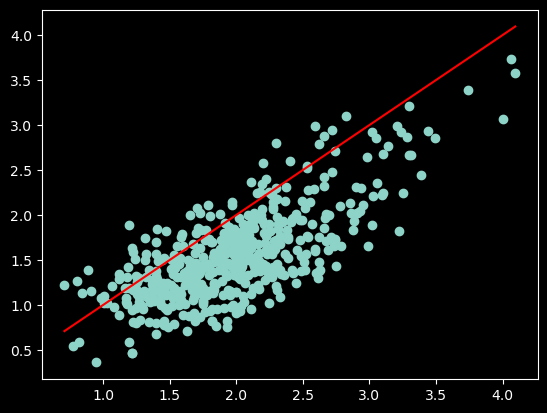

In [21]:
plt.scatter(expos_arr[-1,:], exposures)
# plt.scatter(compute_exposures(triu_obs, Z), exposures)
plt.plot([min(expos_arr[-1,:]), max(expos_arr[-1,:])], [min(expos_arr[-1,:]), max(expos_arr[-1,:])], color='red')

In [22]:
print(np.corrcoef(expos_arr[-1,:], exposures))
# print(np.corrcoef(exposures_sc[-1,:], exposures))
# print(np.corrcoef(compute_exposures(triu_star_noisy, Z), exposures))
print(np.corrcoef(compute_exposures(triu_obs, Z), exposures))

[[1.         0.73161333]
 [0.73161333 1.        ]]
[[1.         0.09572895]
 [0.09572895 1.        ]]


In [23]:
# print 2x2 table of triu_star and new_triu_star
#  for all values
from colorama import init


def binary_contingency_table(A1, A2):
    # Table structure:
    #     A2=0  A2=1
    # A1=0  n00   n01
    # A1=1  n10   n11
    
    n00 = jnp.sum((A1 == 0) & (A2 == 0))
    n01 = jnp.sum((A1 == 0) & (A2 == 1))
    n10 = jnp.sum((A1 == 1) & (A2 == 0))
    n11 = jnp.sum((A1 == 1) & (A2 == 1))
    
    print("A1 \ A2 |  0  |  1  |")
    print("---------|-----|-----|")
    print(f"   0    | {n00:3d} | {n01:3d} |")
    print(f"   1    | {n10:3d} | {n11:3d} |")
    
    return jnp.array([[n00, n01], [n10, n11]])

# print(binary_contingency_table(triu_star, new_triu_star))
print(binary_contingency_table(triu_star, final_carry[1].positions))
print(binary_contingency_table(triu_star, triu_obs))

# print(jnp.mean(triu_star == new_triu_star))
print(jnp.mean(triu_star == final_carry[1].positions))
# print(jnp.mean(triu_star == triu_star_noisy))
print(jnp.mean(triu_star == triu_obs))


# print(jnp.sum(triu_star), jnp.sum(new_triu_star))

A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 102080 | 13256 |
   1    | 7164 | 2250 |
[[102080  13256]
 [  7164   2250]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 91638 | 23698 |
   1    | 2832 | 6582 |
[[91638 23698]
 [ 2832  6582]]
0.8363126
0.7873346


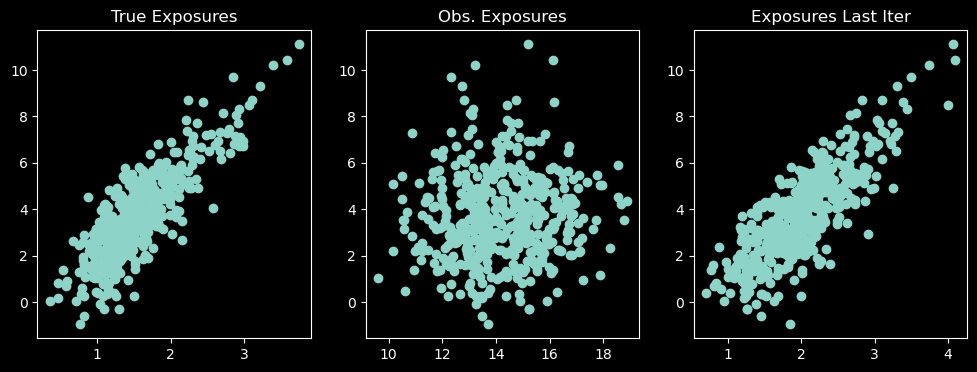

In [24]:
# plot with 3 panels of expos~Y scatter for exposures, expos_obs, expos_arr[-1,:]
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.scatter(exposures, Y-3*Z)
plt.title("True Exposures")
plt.subplot(1, 3, 2)
plt.scatter(expos_obs, Y-3*Z)
plt.title("Obs. Exposures")
plt.subplot(1, 3, 3)
plt.scatter(expos_arr[-1,:], Y-3*Z)
plt.title("Exposures Last Iter")
plt.show()


In [4]:
# Testing blackjax for continuous site (outcome model only)
import blackjax
import blackjax.mcmc.hmc as hmc
from colorama import init
import jax.scipy.stats as stats
import numpyro
import numpyro.distributions as dist
import numpyro.infer.initialization
from numpyro.infer.util import initialize_model


def outcome_model(X, Z, triu_star, Y=None):
    # Outcome model
    expos = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, expos]))

    # priors
    with numpyro.plate("eta_plate", df_nodes.shape[1]):
        eta = numpyro.sample("eta", dist.Normal(0, 5))
    
    # log_sig_y = numpyro.sample("log_sig_y", dist.Normal(0, 1))
    # sig_y = numpyro.sample("sig_y", dist.LogNormal(scale=1.0))
    sig_y = numpyro.sample("sig_y", dist.HalfNormal(2.0))
    # likelihood
    # mean_y = jnp.dot(df_nodes, eta)
    mean_y = df_nodes @ eta
    # numpyro.sample("Y", dist.Normal(mean_y, jnp.exp(log_sig_y)), obs=Y)
    numpyro.sample("Y", dist.Normal(mean_y, sig_y), obs=Y)
    
    
def networks_models(triu_star, triu_obs, df_edges):
    # Proxy nets model
    # priors
    with numpyro.plate("gamma_plate", 1 + df_edges.shape[1]):
        gamma = numpyro.sample("gamma", dist.Normal(0, 5))
    
    # likelihood
    # obs_logits = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    obs_logits = triu_star*gamma[0] + (1 - triu_star)* (df_edges @ gamma[1:])
    # obs_logits = jnp.where(triu_star == 1, gamma[0], gamma[1])
    numpyro.sample("triu_obs", dist.Bernoulli(logits=obs_logits), obs=triu_obs)

    # True network model (given triu_star value)
    # priors
    with numpyro.plate("theta_plate", df_edges.shape[1]):
        theta = numpyro.sample("theta", dist.Normal(0, 5))

    # likelihood
    # star_logits = jnp.dot(df_edges, theta)
    star_logits = df_edges @ theta
    numpyro.sample("triu_star", dist.Bernoulli(logits=star_logits), obs=triu_star)


def true_net_model(triu_star, df_edges):
    # True network model (given triu_star value)
    # priors
    with numpyro.plate("theta_plate", df_edges.shape[1]):
        theta = numpyro.sample("theta", dist.Normal(0, 5))

    # likelihood
    # star_logits = jnp.dot(df_edges, theta)
    star_logits = df_edges @ theta
    numpyro.sample("triu_star", dist.Bernoulli(logits=star_logits), obs=triu_star)

def obs_net_model(triu_star, triu_obs, df_edges):
    # Proxy nets model
    # priors
    with numpyro.plate("gamma_plate", 1 + df_edges.shape[1]):
        gamma = numpyro.sample("gamma", dist.Normal(0, 5))
    
    # likelihood
    # obs_logits = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    obs_logits = triu_star*gamma[0] + (1 - triu_star)* (df_edges @ gamma[1:])
    # obs_logits = jnp.where(triu_star == 1, gamma[0], gamma[1])
    numpyro.sample("triu_obs", dist.Bernoulli(logits=obs_logits), obs=triu_obs)


rng_key, init_key = random.split(key)

init_params_outcome, potential_fn_gen_outcome, *_ = initialize_model(
    init_key,
    outcome_model,
    init_strategy=numpyro.infer.initialization.init_to_value(
        values={
            "eta": jnp.zeros(4),
            "sig_y": 1.0 # due to ExpTransform it equivalence of sig=0
        }
    ),
    # model_args=(x, Z, triu_star, triu_obs, df_edges, Y),
    # model_args=(x, Z, triu_obs, triu_obs, df_edges, Y),
    # model_args=(x, Z, final_carry[1], Y),
    model_args=(x, Z, triu_star, Y),
    # model_args=(x, Z, final_carry[1], Y),
    dynamic_args=True
    )

# logdensity_fn = lambda position: -potential_fn_gen(x, Z, triu_star, Y)(position)
# logdensity_fn = lambda position: -potential_fn_gen(x, Z, triu_star, triu_obs, df_edges, Y)(position)
def logdensity_fn_outcome(vals):
    # return -potential_fn_gen_outcome(x, Z, final_carry[1], Y)(position)
    # return -potential_fn_gen_outcome(x, Z, triu_star, Y)(position)
    return -potential_fn_gen_outcome(x, Z, final_carry[1].positions, Y)(vals)
# logdensity_fn = lambda position: -potential_fn_gen(x, Z, final_carry[1], Y)(position)
initial_position_oc = init_params_outcome.z
print(initial_position_oc)

#  repeat for network model
rng_key, init_key = random.split(key)

init_params_network, potential_fn_gen_network, *_ = initialize_model(
    init_key,
    networks_models,
    # init_strategy=numpyro.infer.initialization.init_to_value(
    #     values={
    #         "gamma": jnp.zeros(1 + df_edges.shape[1]),
    #         "theta": jnp.zeros(df_edges.shape[1])
    #     }
    # ),
    model_args=(triu_star, triu_obs, df_edges),
    dynamic_args=True
    )


def logdensity_fn_network(vals):
    # return -potential_fn_gen_network(triu_star, triu_obs, df_edges)(position)
    return -potential_fn_gen_network(final_carry[1].positions, triu_obs, df_edges)(vals)

rng_key, init_key = random.split(key)

init_param_true_net, potential_fn_gen_true_net, *_ = initialize_model(
    init_key,
    true_net_model,
    model_args=(triu_star, df_edges),
    dynamic_args=True
    )

def logdensity_fn_true_net(vals):
    return -potential_fn_gen_true_net(triu_star, df_edges)(vals)

rng_key, init_key = random.split(key)

init_param_obs_net, potential_fn_gen_obs_net, *_ = initialize_model(
    init_key,
    obs_net_model,
    model_args=(triu_star, triu_obs, df_edges),
    dynamic_args=True
    )

def logdensity_fn_obs_net(vals):
    return -potential_fn_gen_obs_net(triu_star, triu_obs, df_edges)(vals)



initial_position_net = init_params_network.z
print(initial_position_net)

{'eta': Array([0., 0., 0., 0.], dtype=float32), 'sig_y': Array(0., dtype=float32, weak_type=True)}
{'gamma': Array([ 1.0726709 ,  1.292417  , -0.6919451 , -0.33128738], dtype=float32), 'theta': Array([-0.34906197,  1.3183036 , -1.382731  ], dtype=float32)}


In [26]:
rng_key, warmup_key = random.split(rng_key)

step_size = 1e-1
# mala kernel
# mala_oc = blackjax.mala(logdensity_fn_outcome, step_size)
mala_oc = blackjax.mala.build_kernel()
# init state
# state = mala_oc.init(initial_position_oc)
state = blackjax.mala.init(initial_position_oc, logdensity_fn_outcome)
# jit compile the kernel step function
# step = jax.jit(mala_oc.step)   
# new_state, info = step(rng_key, state)
new_state, info = mala_oc(rng_key, state, logdensity_fn_outcome, step_size)
print(new_state.position["eta"], type(new_state.position["eta"]),
       "\n", new_state.position["sig_y"], type(new_state.position["sig_y"]))
print(state.position)

[0. 0. 0. 0.] <class 'jaxlib.xla_extension.ArrayImpl'> 
 0.0 <class 'jaxlib.xla_extension.ArrayImpl'>
{'eta': Array([0., 0., 0., 0.], dtype=float32), 'sig_y': Array(0., dtype=float32, weak_type=True)}


In [27]:
%%time


class AdaptState(NamedTuple):
    state: Any  # MALA state
    step_size: float
    mean_acceptance: float
    iteration: int  
    # dual_averaging_state: Any  # Include the dual averaging state


def adaptive_step_size_mala(cur_step_size, acc_rate, target_rate, adapt_rate):
    log_step = jnp.log(cur_step_size)
    log_step = log_step + adapt_rate * (acc_rate - target_rate)
    new_step_size = jnp.exp(log_step)
    return new_step_size

def inference_loop(
    rng_key, 
    kernel, 
    initial_state, 
    logdensity_fn, 
    initial_step_size: float,
    num_samples: int,
    adapt_window: int = 1,  # New parameter
    target_acceptance: float = 0.8,
    adaptation_rate: float = 0.1,
    num_warmpup: int = 5000,
):
    def one_step(carry, key):
        adapt_state = carry
        
        # Run MALA step
        new_state, info = kernel(
            key, 
            adapt_state.state, 
            logdensity_fn, 
            adapt_state.step_size
        )
        
       

        # Update step size only every adapt_every iterations
        should_adapt = ((adapt_state.iteration + 1) % adapt_window == 0) & (adapt_state.iteration < num_warmpup)
       
        #  # Update dual averaging state conditionally
        # def adapt_fn(adapt_state, info):
        #     gradient = info.acceptance_rate - target_acceptance
        #     new_da_state = update_da(adapt_state.dual_averaging_state, gradient)
        #     new_step_size = jnp.exp(new_da_state.log_x)
        #     return new_da_state, new_step_size

        # def no_adapt_fn(adapt_state, info):
        #     return adapt_state.dual_averaging_state, adapt_state.step_size

        # new_da_state, new_step_size = jax.lax.cond(
        #     should_adapt,
        #     lambda _: adapt_fn(adapt_state, info),
        #     lambda _: no_adapt_fn(adapt_state, info),
        #     operand=None
        # )

        # if last warmup step then new_step_size = jnp.exp(new_da_state.log_x)
        # new_step_size = jnp.where(
        #     should_adapt,
        #     jnp.exp(new_da_state.log_x),
        #     new_step_size
        # )

        new_step_size = jnp.where(
            should_adapt,
            adaptive_step_size_mala(adapt_state.step_size, 
                                    info.acceptance_rate,
                                    target_acceptance,
                                    adaptation_rate),
            adapt_state.step_size
        )
        
        # Update mean acceptance rate
        new_mean_acc = adapt_state.mean_acceptance + (
            info.acceptance_rate - adapt_state.mean_acceptance
        ) / (adapt_state.iteration + 1) # Running average accept rate 
        
        new_adapt_state = AdaptState(
            state=new_state,
            step_size=new_step_size,
            mean_acceptance=new_mean_acc,
            iteration=adapt_state.iteration + 1,
            # dual_averaging_state=new_da_state
        )
        
        return new_adapt_state, (new_state, info.acceptance_rate, new_step_size)

    keys = random.split(rng_key, num_samples)

    # Initialize dual averaging state
    # da_state = init_da(initial_step_size)

    init_adapt_state = AdaptState(
        state=initial_state,
        step_size=initial_step_size,
        mean_acceptance=0.0,
        iteration=0,
        # dual_averaging_state=da_state
    )
    
    _, (states, acc_rates, step_sizes) = jax.lax.scan(one_step, init_adapt_state, keys)
    
    # final_step_size = final_da(final_state.dual_averaging_state)

    # return states, acc_rates, step_sizes, final_step_size
    return states, acc_rates, step_sizes
# Usage:
sample_key, warmup_key = random.split(warmup_key)

states, acc_rates, step_sizes = inference_loop(
    sample_key,
    mala_oc,
    state, 
    logdensity_fn_outcome,
    initial_step_size=1e-2,
    num_samples=10000,
    target_acceptance=0.8
)

CPU times: total: 1.95 s
Wall time: 2.02 s


0.75846606 0.00036590197


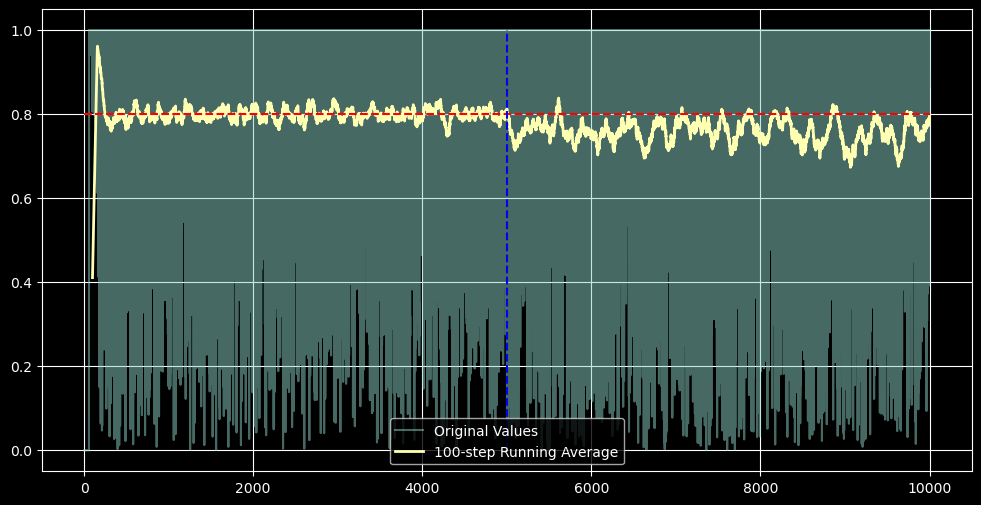

In [28]:
print(acc_rates[5000:].mean(), step_sizes[-1])
# plt.subplot(1, 2, 1)
# # plt.plot(step_sizes)
# plt.plot(step_sizes)
# plt.subplot(1, 2, 2)
# plt.plot(acc_rates)
def plot_running_average(values, window=100, hline = True, num_warmpup=5000, target_rate=0.8):
    # Calculate running average
    running_avg = np.convolve(values, np.ones(window)/window, mode='valid')
    
    # Create x-axis values
    x_orig = np.arange(len(values))
    x_avg = np.arange(window-1, len(values))
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(x_orig, values, alpha=0.5, label='Original Values')
    plt.plot(x_avg, running_avg, linewidth=2, label=f'{window}-step Running Average')
    if hline:
        plt.hlines(target_rate, 0, len(x_orig), color='red', linestyle='--')
        plt.vlines(num_warmpup, 0, 1, color='blue', linestyle='--')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_running_average(acc_rates)

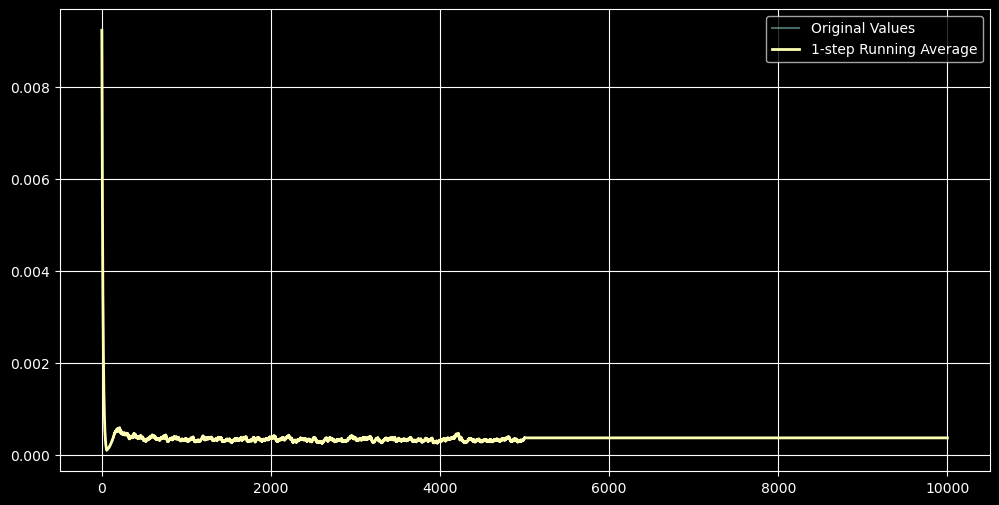

In [29]:
plot_running_average(step_sizes, hline=False, window=1)

In [30]:
# acceptance_rate = np.mean(infos)
# num_divergent = np.mean(infos[1])

print(f"\Average acceptance rate: {acc_rates[5000:].mean():.2f}")

print("true gamma: ", gamma, "\n",
      "true eta: ", eta, "\n",
      "true theta: ", theta)

# print(f"There were {100*num_divergent:.2f}% divergent transitions")

\Average acceptance rate: 0.76
true gamma:  [ 0.84729785 -1.3862944   0.1        -0.5       ] 
 true eta:  [-1.    3.   -0.25  3.  ] 
 true theta:  [-2.5  -0.25  1.  ]


In [31]:
post = {"eta" : states.position["eta"][5000:,][None, ...], 
        # "sig_y" : states.position["sig_y"][20000:,][None, ...],}
        "sig_y" : jnp.exp(states.position["sig_y"][5000:,][None, ...]),}
        # "sig_y" : jnp.exp(states.position["log_sig_y"][20000:,][None, ...]),}

print(post["eta"].shape, post["sig_y"].shape)

(1, 5000, 4) (1, 5000)


In [32]:
import arviz as az

# idata = az.from_dict(posterior={k: v[None, ...] for k, v in states.position.items()}, )
idata = az.from_dict(posterior=post)
az.summary(idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta[0],-3.179,0.208,-3.548,-2.787,0.045,0.032,22.0,51.0,NaN
eta[1],4.168,0.090,3.995,4.330,0.015,0.011,34.0,81.0,NaN
eta[2],-0.163,0.046,-0.242,-0.069,0.002,0.002,390.0,1002.0,NaN
eta[3],3.170,0.090,2.988,3.317,0.019,0.013,24.0,70.0,NaN
sig_y,0.989,0.032,0.926,1.045,0.001,0.001,943.0,1596.0,NaN


array([[<Axes: title={'center': 'eta'}>, <Axes: title={'center': 'eta'}>],
       [<Axes: title={'center': 'sig_y'}>,
        <Axes: title={'center': 'sig_y'}>]], dtype=object)

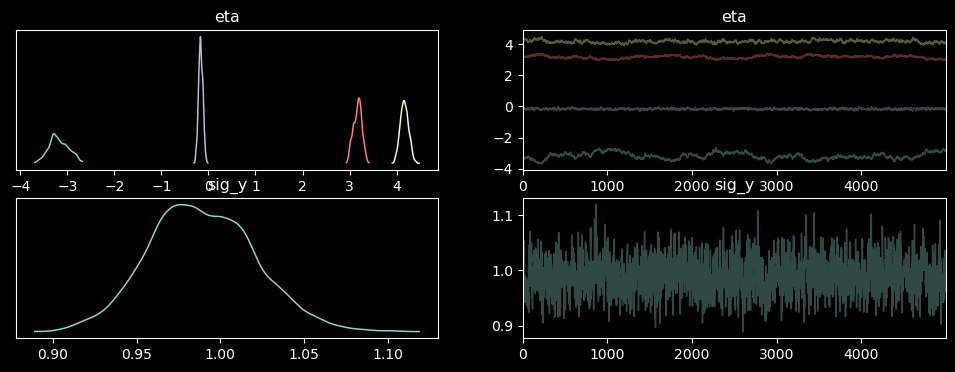

In [33]:
az.plot_trace(idata, var_names=["eta", "sig_y"])

In [34]:
# run MALA for network model

rng_key, warmup_key = random.split(rng_key)

step_size = 1e-1
# mala kernel
# mala_oc = blackjax.mala(logdensity_fn_outcome, step_size)
mala_net = blackjax.mala.build_kernel()
# init state
# state = mala_oc.init(initial_position_oc)
state = blackjax.mala.init(initial_position_net, logdensity_fn_network)
# jit compile the kernel step function
# step = jax.jit(mala_oc.step)   
# new_state, info = step(rng_key, state)
new_state, info = mala_oc(rng_key, state, logdensity_fn_network, step_size)
print(new_state.position["gamma"], type(new_state.position["gamma"]),
         "\n", new_state.position["theta"], type(new_state.position["theta"]))
print(state.position)


[-0.6888647   0.08883381 -1.0095253  -0.9617739 ] <class 'jaxlib.xla_extension.ArrayImpl'> 
 [ 0.4629445  1.3932247 -1.3859057] <class 'jaxlib.xla_extension.ArrayImpl'>
{'gamma': Array([-0.6888647 ,  0.08883381, -1.0095253 , -0.9617739 ], dtype=float32), 'theta': Array([ 0.4629445,  1.3932247, -1.3859057], dtype=float32)}


In [35]:
%%time

sample_key,_ = random.split(key)
net_states, net_acc_rates, net_step_sizes = inference_loop(
    sample_key,
    mala_net,
    state, 
    logdensity_fn_network,
    initial_step_size=1e-2,
    num_samples=10000,
    target_acceptance=0.8
)

CPU times: total: 33.1 s
Wall time: 30.8 s


0.79339254 1.7792998e-05


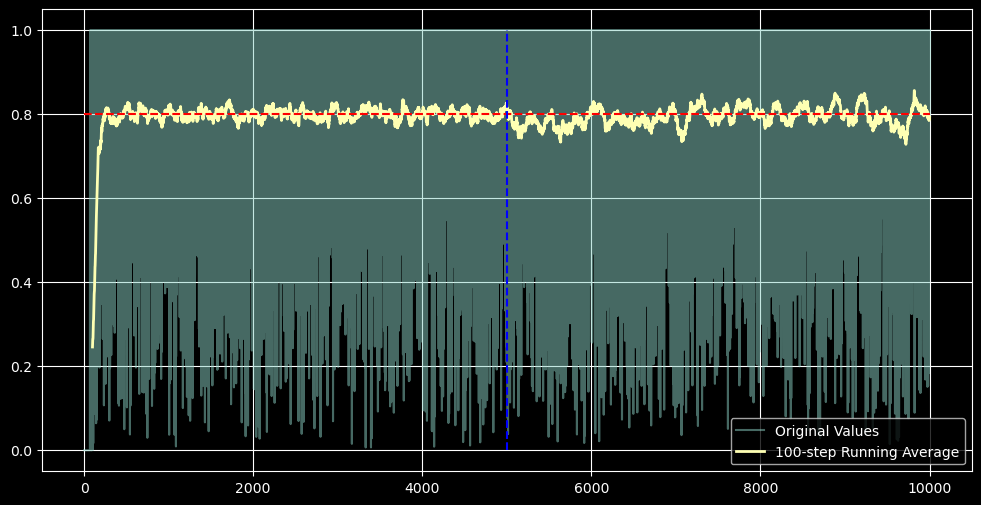

In [36]:
print(net_acc_rates[5000:].mean(), net_step_sizes[-1])
plot_running_average(net_acc_rates)

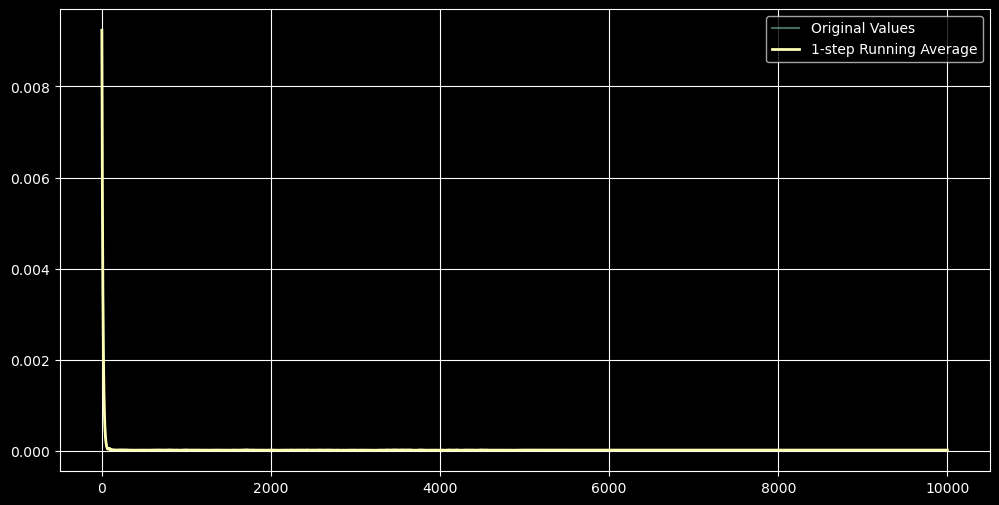

In [37]:
plot_running_average(net_step_sizes, hline=False, window=1)

In [38]:
print("true gamma: ", gamma, "\n",
      "true eta: ", eta, "\n",
      "true theta: ", theta)

net_post = {"gamma" : net_states.position["gamma"][5000:,][None, ...],
            "theta" : net_states.position["theta"][5000:,][None, ...],}



true gamma:  [ 0.84729785 -1.3862944   0.1        -0.5       ] 
 true eta:  [-1.    3.   -0.25  3.  ] 
 true theta:  [-2.5  -0.25  1.  ]


In [39]:
idata_net = az.from_dict(posterior=net_post)
az.summary(idata_net)

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],0.229,0.016,0.200,0.260,0.001,0.001,153.0,266.0,NaN
gamma[1],-1.440,0.013,-1.465,-1.417,0.001,0.001,124.0,423.0,NaN
gamma[2],0.076,0.009,0.059,0.093,0.001,0.000,172.0,576.0,NaN
gamma[3],-0.242,0.022,-0.284,-0.202,0.003,0.002,71.0,135.0,NaN
theta[0],-1.935,0.016,-1.967,-1.905,0.002,0.001,102.0,253.0,NaN
theta[1],-0.097,0.012,-0.120,-0.075,0.001,0.001,139.0,398.0,NaN
theta[2],0.403,0.021,0.365,0.443,0.002,0.002,95.0,129.0,NaN


array([[<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>]], dtype=object)

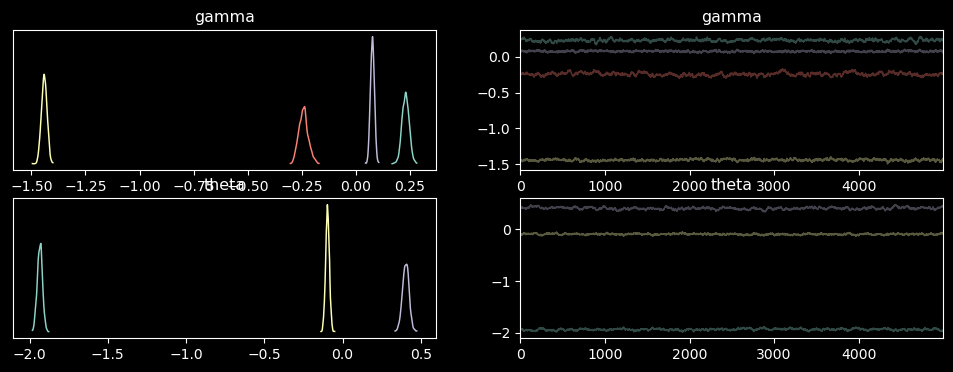

In [40]:
az.plot_trace(idata_net, var_names=["gamma", "theta"])

In [41]:
class Obs_Data(NamedTuple):
    x: Any
    Z: Any
    Y: Any
    df_edges: Any
    triu_obs: Any


obs_data = Obs_Data(x, Z, Y, df_edges, triu_obs)

print(obs_data.df_edges.shape, jnp.all(obs_data.df_edges == df_edges))


(124750, 3) True


In [42]:
# triu_obs + some noise
# triu_obs_noisy = (triu_star * random.binomial(key, n=1, p=0.95, shape=(triu_dim,)) +
                #    (1-triu_star) * random.binomial(key, n=1, p=0.01, shape=(triu_dim,)))
noisy_key,_ = random.split(key)
triu_obs_noisy = random.bernoulli(noisy_key, 0.1, shape=(triu_dim,))
triu_obs_noisy = jnp.array(triu_obs_noisy, dtype=jnp.float32)

In [43]:
# get init values for MWG by computing MAP for continuous values
from numpyro.infer import SVI, Trace_ELBO, autoguide
import numpyro.optim as optim



# get MAP for true net

true_net_guide = autoguide.AutoDelta(true_net_model)  # AutoDelta gives MAP estimates

# Initialize the optimizer
optimizer = optim.Adam(step_size=0.01)

# Setup SVI
true_net_svi = SVI(
    model=true_net_model,
    guide=true_net_guide,
    optim=optimizer,
    loss=Trace_ELBO()
)

# Run SVI
true_net_result = true_net_svi.run(
    rng_key=random.split(key)[0],
    num_steps=5000,
    triu_star=triu_obs_noisy,
    df_edges=df_edges
)

# Get MAP estimates
init_true_net_params = true_net_guide.median(true_net_result.params)

print(init_true_net_params)
print(theta)

100%|██████████| 5000/5000 [00:09<00:00, 549.54it/s, init loss: 184060.1250, avg. loss [4751-5000]: 40435.4807]


{'theta': Array([-2.220282  ,  0.01391055,  0.01751397], dtype=float32)}
[-2.5  -0.25  1.  ]


In [44]:
def init_triu_star_from_prior(key, init_theta, df_edges):
    key1, _ = random.split(key)
    star_logits = jnp.dot(df_edges, init_theta)
    star_probs = expit(star_logits)
    init_triu_star = jnp.array(rng.binomial(n=1, p=star_probs, size=TRIU_LEN), dtype=jnp.float32)
    return init_triu_star


init_triu_star = init_triu_star_from_prior(key, init_true_net_params["theta"], df_edges)


In [45]:
print(jnp.mean(triu_star == init_triu_star))
print(jnp.mean(triu_star == triu_obs))
print(jnp.mean(triu_star == triu_obs_noisy))

print(binary_contingency_table(triu_star, triu_obs))
print(binary_contingency_table(triu_star, triu_obs_noisy))
print(binary_contingency_table(triu_star, init_triu_star))


0.84187573
0.7873346
0.84025645
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 91638 | 23698 |
   1    | 2832 | 6582 |
[[91638 23698]
 [ 2832  6582]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 103870 | 11466 |
   1    | 8462 | 952 |
[[103870  11466]
 [  8462    952]]
A1 \ A2 |  0  |  1  |
---------|-----|-----|
   0    | 104059 | 11277 |
   1    | 8449 | 965 |
[[104059  11277]
 [  8449    965]]


In [46]:



# Setup the guide (variational distribution)
outcome_guide = autoguide.AutoDelta(outcome_model)  # AutoDelta gives MAP estimates

# Initialize the optimizer
optimizer = optim.Adam(step_size=0.01)

# Setup SVI
outcome_svi = SVI(
    model=outcome_model,
    guide=outcome_guide,
    optim=optimizer,
    loss=Trace_ELBO()
)

# Run SVI
outcome_result = outcome_svi.run(
    rng_key=random.split(key)[0],
    num_steps=5000,
    X=x,
    Z=Z,
    triu_star=init_triu_star,
    # triu_star=triu_obs_noisy,
    Y=Y
)

# Get MAP estimates
init_outcome_params = outcome_guide.median(outcome_result.params)

print(init_outcome_params)
print(eta, sig_y)

init_outcome_params["sig_y"] = jnp.log(init_outcome_params["sig_y"])
print(init_outcome_params)



100%|██████████| 5000/5000 [00:09<00:00, 507.57it/s, init loss: 9265.2705, avg. loss [4751-5000]: 1034.3940]


{'eta': Array([ 2.5089529 ,  3.0265434 , -0.1680156 ,  0.49415922], dtype=float32), 'sig_y': Array(1.868197, dtype=float32)}
[-1.    3.   -0.25  3.  ] 1
{'eta': Array([ 2.5089529 ,  3.0265434 , -0.1680156 ,  0.49415922], dtype=float32), 'sig_y': Array(0.6249738, dtype=float32)}


In [47]:
# get MAP for obs net

obs_net_guide = autoguide.AutoDelta(obs_net_model)  # AutoDelta gives MAP estimates

# Initialize the optimizer
optimizer = optim.Adam(step_size=0.01)

# Setup SVI
obs_net_svi = SVI(
    model=obs_net_model,
    guide=obs_net_guide,
    optim=optimizer,
    loss=Trace_ELBO()
)

# Run SVI
obs_net_result = obs_net_svi.run(
    rng_key=random.split(key)[0],
    num_steps=5000,
    triu_star=init_triu_star,
    triu_obs=triu_obs,
    df_edges=df_edges
)

# Get MAP estimates
init_obs_net_params = obs_net_guide.median(obs_net_result.params)

print(init_obs_net_params)
print(gamma)

100%|██████████| 5000/5000 [00:13<00:00, 363.48it/s, init loss: 165576.4375, avg. loss [4751-5000]: 69125.2188]


{'gamma': Array([-1.1018633 , -1.170787  ,  0.03989992, -0.07628209], dtype=float32)}
[ 0.84729785 -1.3862944   0.1        -0.5       ]


In [48]:
# re init theta

true_net_guide = autoguide.AutoDelta(true_net_model)  # AutoDelta gives MAP estimates

# Initialize the optimizer
optimizer = optim.Adam(step_size=0.01)

# Setup SVI
true_net_svi = SVI(
    model=true_net_model,
    guide=true_net_guide,
    optim=optimizer,
    loss=Trace_ELBO()
)

# Run SVI
true_net_result2 = true_net_svi.run(
    rng_key=random.split(key)[0],
    num_steps=5000,
    triu_star=init_triu_star,
    df_edges=df_edges
)

# Get MAP estimates
init_true_net_params2 = true_net_guide.median(true_net_result2.params)

print(init_true_net_params2)
print(theta)
print(init_true_net_params)

100%|██████████| 5000/5000 [00:09<00:00, 502.76it/s, init loss: 184317.2812, avg. loss [4751-5000]: 40045.9682]


{'theta': Array([-2.240843  ,  0.01754432,  0.02210296], dtype=float32)}
[-2.5  -0.25  1.  ]
{'theta': Array([-2.220282  ,  0.01391055,  0.01751397], dtype=float32)}


mean true expos:  1.5582967 
 mean random expos:  2.4087617 
 mean init expos:  2.350405
corr true vs random:  [[1.         0.00870653]
 [0.00870653 1.        ]] 
 corr true vs init:  [[1.         0.07978095]
 [0.07978095 1.        ]]
corr Y with true expos:  [[1.         0.64833367]
 [0.64833367 1.        ]] 
 corr Y with random expos:  [[ 1.         -0.00584484]
 [-0.00584484  1.        ]] 
 corr Y with init expos:  [[1.         0.01075611]
 [0.01075611 1.        ]]


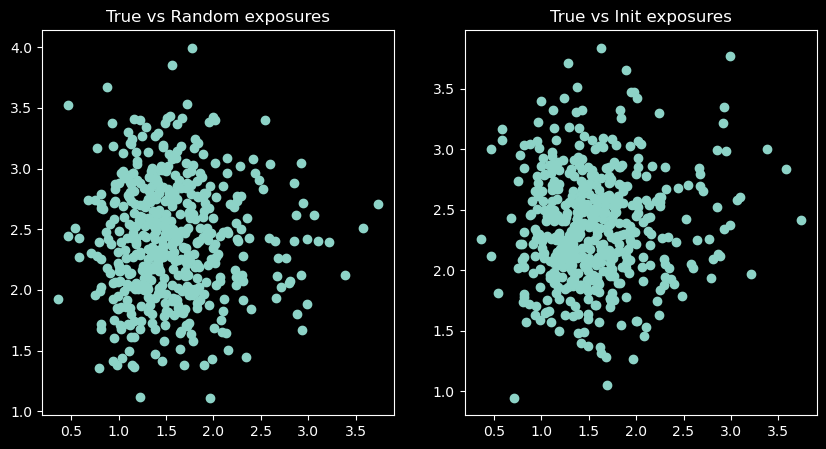

In [49]:
rand_expos = compute_exposures(triu_obs_noisy, Z)
init_expos = compute_exposures(init_triu_star, Z)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(exposures, rand_expos)
axs[0].set_title("True vs Random exposures")

axs[1].scatter(exposures, init_expos)
axs[1].set_title("True vs Init exposures")

print("mean true expos: ", exposures.mean(), "\n",
        "mean random expos: ", rand_expos.mean(), "\n",
        "mean init expos: ", init_expos.mean())

print("corr true vs random: ", np.corrcoef(exposures, rand_expos), "\n",
      "corr true vs init: ", np.corrcoef(exposures, init_expos))

print("corr Y with true expos: ", np.corrcoef(Y, exposures), "\n",
      "corr Y with random expos: ", np.corrcoef(Y, rand_expos), "\n",
      "corr Y with init expos: ", np.corrcoef(Y, init_expos))

In [50]:
### Metroplis-Within-Gibbs Kernel ###
 
# 1. Define the log posterior function

# outcome model log posterior (log density)
def logdensity_Y(position, cur_triu_star):
    return -potential_fn_gen_outcome(x, Z, cur_triu_star, Y)(position)

# network model log posterior (log density)
def logdensity_nets(position, cur_triu_star):
    return -potential_fn_gen_network(cur_triu_star, triu_obs, df_edges)(position)

# true net model log posterior (log density)
def logdensity_true_net(position, cur_triu_star):
    return -potential_fn_gen_true_net(cur_triu_star, df_edges)(position)

# obs net model log posterior (log density)
def logdensity_obs_net(position, cur_triu_star):
    return -potential_fn_gen_obs_net(cur_triu_star, triu_obs, df_edges)(position)

#  Kernels (marginal)

mala_step_y = blackjax.mala.build_kernel()
# mala_step_nets = blackjax.mala.build_kernel()
mala_step_true_net = blackjax.mala.build_kernel()
mala_step_obs_net = blackjax.mala.build_kernel()

mala_init_y = blackjax.mala.init
# mala_init_nets = blackjax.mala.init
mala_init_true_net = blackjax.mala.init
mala_init_obs_net = blackjax.mala.init

# GWG kernel given observed data
def gwg_step(rng_key_, state_, theta_, gamma_, eta_, sig_y_, step_size, anneal_):
    return GWG_kernel(rng_key_, state_, triu_obs, df_edges, theta_, gamma_,
                Y, x, Z, eta_, sig_y_, step_size, anneal_)
    

True logpost:  -251.99164 
 Init logpost:  -562.8895 
 Init param logpost:  -522.9393 
 Init triu logpost:  -2655.8542
cor annealed scores:  [[1.         0.35810478]
 [0.35810478 1.        ]]


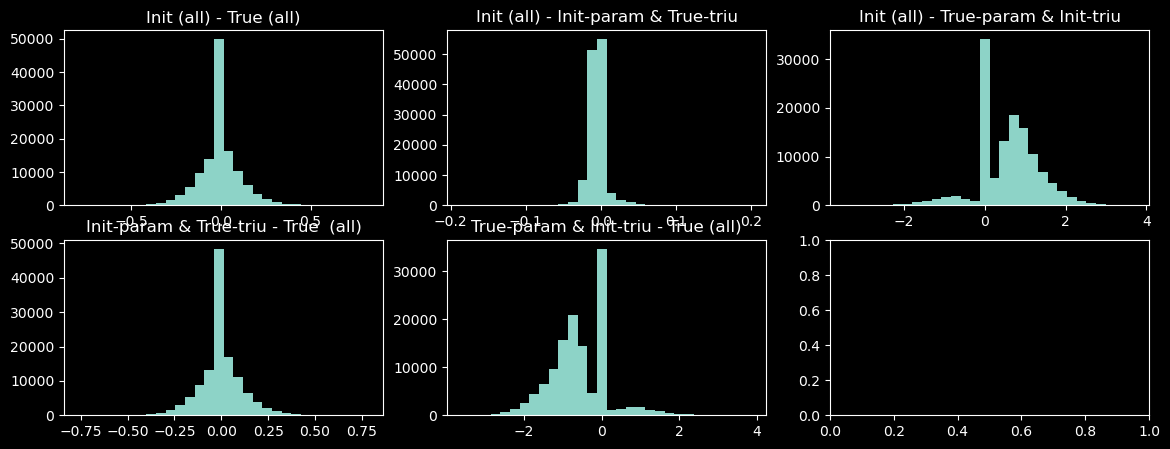

In [51]:
# testing val_grad_fn with annealing

# @jax.jit
# def annealed_A_star_cond_logpost(triu_star, triu_obs, df_edges, theta, gamma, Y, X, Z, eta, sig_y,
#                                  anneal=1.0):
#     # p(A*|X,\theta)
#     logits_a_star = jnp.dot(df_edges, theta)
#     # a_star_log_likelihood = triu_star * (-jnp.log1p(jnp.exp(-logits_a_star))) + (1 - triu_star) * (-jnp.log1p(jnp.exp(logits_a_star)))
#     a_star_log_likelihood = triu_star*logits_a_star - jnp.log1p(jnp.exp(logits_a_star))

#     # p(A|A*,X,\gamma)
#     logits_a_obs = (triu_star * gamma[0]) + (1 - triu_star) * jnp.dot(df_edges, gamma[1:])
#     # logits_a_obs = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
#     # a_obs_log_likelihood = triu_obs * (-jnp.log1p(jnp.exp(-logits_a_obs))) + (1 - triu_obs) * (-jnp.log1p(jnp.exp(logits_a_obs)))
#     a_obs_log_likelihood = triu_obs*logits_a_obs - jnp.log1p(jnp.exp(logits_a_obs))

#     # p(Y|A*,X,Z,\eta,\sig_y)
#     exposures = compute_exposures(triu_star, Z)
#     df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, exposures]))
#     mean_y = jnp.dot(df_nodes, eta)
#     y_log_likelihood = - 0.5 * jnp.sum((Y - mean_y)**2) / sig_y**2 - n * jnp.log(sig_y)

#     # A_star_log_post = jnp.sum(a_star_log_likelihood) 
#     # annealed_log_post = (1- anneal)*(jnp.sum(a_obs_log_likelihood) + jnp.sum(y_log_likelihood))
    
#     # return A_star_log_post + annealed_log_post

#     annealed_log_post = (1-anneal)*(jnp.sum(a_star_log_likelihood) + jnp.sum(a_obs_log_likelihood))
#     return annealed_log_post + jnp.sum(y_log_likelihood)



# annealead_val_grad_fn = jax.value_and_grad(annealed_A_star_cond_logpost)

# test annealed_val_grad_fn with init_theta and init_triu_star vs true values

true_logpost, true_grad = annealead_val_grad_fn(triu_star, triu_obs, df_edges,
                                        theta, gamma, Y, x, Z, eta, sig_y,
                                        anneal=1.0)

init_logpost, init_grad = annealead_val_grad_fn(init_triu_star, triu_obs, df_edges,
                                        init_true_net_params["theta"], 
                                        init_obs_net_params["gamma"],
                                          Y, x, Z,
                                            init_outcome_params["eta"],
                                              jnp.exp(init_outcome_params["sig_y"]),
                                        anneal=1.0)

logpost_init_param, grad_init_param = annealead_val_grad_fn(triu_star, triu_obs, df_edges,
                                        init_true_net_params["theta"], 
                                        init_obs_net_params["gamma"],
                                          Y, x, Z,
                                            init_outcome_params["eta"],
                                              jnp.exp(init_outcome_params["sig_y"]),
                                        anneal=1.0)

logpost_init_triu, grad_init_triu = annealead_val_grad_fn(init_triu_star, triu_obs, df_edges,
                                        theta, gamma, Y, x, Z, eta, sig_y,
                                        anneal=1.0)

true_anneal_scores = -(2*triu_star -1)*true_grad / 2
init_anneal_scores = -(2*init_triu_star -1)*init_grad / 2
init_param_anneal_scores = -(2*triu_star -1)*grad_init_param / 2
init_triu_anneal_scores = -(2*init_triu_star -1)*grad_init_triu / 2

print("True logpost: ", true_logpost, "\n",
      "Init logpost: ", init_logpost, "\n",
      "Init param logpost: ", logpost_init_param, "\n",
      "Init triu logpost: ", logpost_init_triu)

fig, axs = plt.subplots(2, 3, figsize=(14, 5))

axs[0,0].hist(init_anneal_scores - true_anneal_scores, bins=30)
axs[0,0].set_title("Init (all) - True (all)")

axs[0,1].hist(init_anneal_scores - init_param_anneal_scores, bins=30)
axs[0,1].set_title("Init (all) - Init-param & True-triu")

axs[0,2].hist(init_anneal_scores - init_triu_anneal_scores, bins=30)
axs[0,2].set_title("Init (all) - True-param & Init-triu")

axs[1,0].hist(init_param_anneal_scores - true_anneal_scores, bins=30)
axs[1,0].set_title("Init-param & True-triu - True  (all)")

axs[1,1].hist(init_triu_anneal_scores - true_anneal_scores, bins=30)
axs[1,1].set_title("True-param & Init-triu - True (all)")

# So most crucial is to get the *init params (eta,gamma,theta)* right!


print("cor annealed scores: ", np.corrcoef(true_anneal_scores, init_anneal_scores))


cor annealed scores:  [[1.         0.35810478]
 [0.35810478 1.        ]]


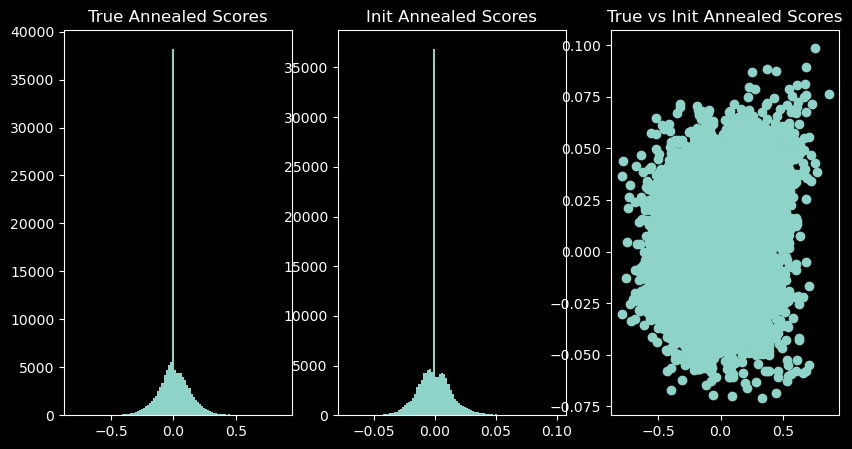

In [52]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].hist(true_anneal_scores, bins=100)
axs[0].set_title("True Annealed Scores")

axs[1].hist(init_anneal_scores, bins=100)
axs[1].set_title("Init Annealed Scores")

# maskinit = init_anneal_scores > 0

# axs[2].scatter(true_anneal_scores[maskinit], init_anneal_scores[maskinit])
axs[2].scatter(true_anneal_scores, init_anneal_scores)
axs[2].set_title("True vs Init Annealed Scores")

print("cor annealed scores: ", np.corrcoef(true_anneal_scores, init_anneal_scores))


cor annealed scores:  [[1.         0.35810457]
 [0.35810457 1.        ]]


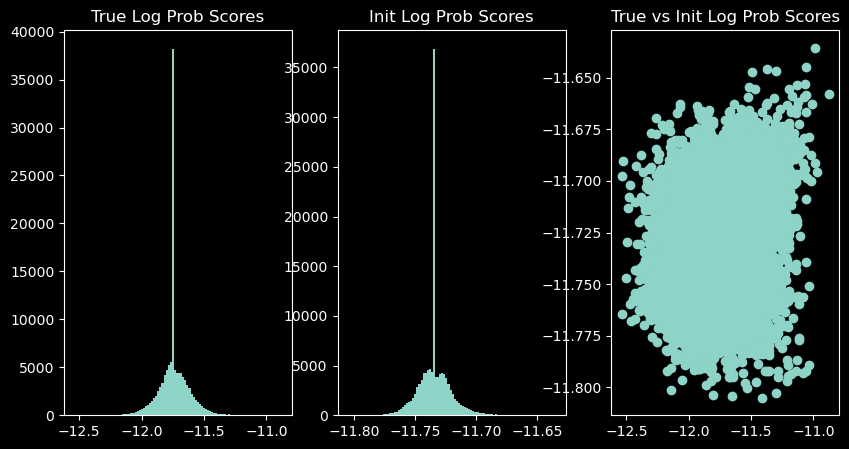

In [133]:
true_log_prob_scores = jax.nn.log_softmax(true_anneal_scores)
init_log_prob_scores = jax.nn.log_softmax(init_anneal_scores)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].hist(true_log_prob_scores, bins=100)
axs[0].set_title("True Log Prob Scores")

axs[1].hist(init_log_prob_scores, bins=100)
axs[1].set_title("Init Log Prob Scores")

axs[2].scatter(true_log_prob_scores, init_log_prob_scores)
axs[2].set_title("True vs Init Log Prob Scores")

print("cor annealed scores: ", np.corrcoef(true_log_prob_scores, init_log_prob_scores))

In [ ]:
init_outcome_params["eta"] += jnp.array([0,0,0,1.5])


In [53]:
f_init, grad_init = annealead_val_grad_fn(init_triu_star,
                                    triu_obs,
                                    df_edges,
                                    init_true_net_params["theta"],
                                    init_obs_net_params["gamma"],
                                    Y, x, Z,
                                    # init_outcome_params["eta"],
                                    eta,
                                    # jnp.exp(init_outcome_params["sig_y"]),
                                    sig_y,
                                    anneal=1.0)
# (f_init,_), grad_init = val_grad_fn(triu_star_noisy,
#                                     triu_obs,
#                                     df_edges,
#                                     initial_position_net["theta"],
#                                     initial_position_net["gamma"],
#                                     Y, x, Z,
#                                     initial_position_oc["eta"],
#                                     jnp.exp(initial_position_oc["sig_y"]))

init_scores = (-(2*init_triu_star-1)*grad_init)/2

init_states = {
    "Y": mala_init_y(position=init_outcome_params,
                    logdensity_fn=lambda vals: logdensity_Y(vals, init_triu_star)),
    "true_net": mala_init_true_net(position=init_true_net_params,
                                    logdensity_fn=lambda vals: logdensity_true_net(vals,
                                                                                    init_triu_star)),
    "obs_net": mala_init_obs_net(position=init_obs_net_params,
                                logdensity_fn=lambda vals: logdensity_obs_net(vals,
                                                                            init_triu_star)),                                                                           
    "triu_star": IPState(init_triu_star, f_init, grad_init, init_scores)
}


In [ ]:
@jax.jit
def RW_kernel(rng_key, state, triu_obs, df_edges, theta, gamma,
              Y, X, Z, eta, sig_y):
    """Single edge flip random walk kernel"""
    key1, key2 = random.split(rng_key)
    
    # Select single random edge
    idx = random.randint(key1, shape=(1,), minval=0, maxval=TRIU_LEN)
    
    # Propose flip
    new_triu_star = state.positions.at[idx].set(1 - state.positions[idx])
    
    # Compute likelihood ratio
    f_proposed, _ = A_star_cond_log_post_with_Y(new_triu_star, triu_obs, df_edges,
                                   theta, gamma, Y, X, Z, eta, sig_y)
    
    # Simple MH acceptance
    acceptance_ratio = jnp.clip(jnp.exp(f_proposed - state.logdensity), a_max=1)
    accept = random.uniform(key2) <= acceptance_ratio
    
    new_triu_star = jax.lax.select(accept, new_triu_star, state.positions)
    new_logpost = jax.lax.select(accept, f_proposed, state.logdensity)
    
    state = IPState(new_triu_star, new_logpost, 0.0, 0.0)  # Grad/scores not needed
    info = IPInfo(acceptance_ratio, accept)
    
    return state, info

In [54]:
class GWGadaptState(NamedTuple):
    states: Any
    step_sizes: Any
    mean_acceptances: Any
    iteration: int
    anneal: Any

def GWG_only_loop(rng_key, init_state, init_step_size, 
                  theta_, gamma_, eta_, sig_y_,
                  num_samples=500,
                  target_acceptance=0.574, adapt_window=1,
                    adaptation_rate=0.01, num_warmup=500,
                    init_anneal = 1.0, anneal_sched = 0.0005,
                    num_rw_steps=2000):
    
    def one_step(carry, key):
        adapt_state = carry
        new_states, info = gwg_step(rng_key_=key,
                                    state_= adapt_state.states,
                                    theta_ = theta_,
                                    gamma_ = gamma_,
                                    eta_ = eta_,
                                    sig_y_ = jnp.exp(sig_y_),
                                    step_size = adapt_state.step_sizes,
                                    anneal_ = adapt_state.anneal)
        new_step_size = jnp.where(
            (adapt_state.iteration + 1) % adapt_window == 0,
            adaptive_step_size(adapt_state.step_sizes,
                                info.acceptance_rate, target_acceptance, adaptation_rate),
            adapt_state.step_sizes
        )

        new_mean_acc = adapt_state.mean_acceptances + (
            info.acceptance_rate - adapt_state.mean_acceptances
        ) / (adapt_state.iteration + 1)

        # new_anneal = jnp.maximum(adapt_state.anneal - adapt_state.iteration / num_warmup, 0.0)
        # new_anneal = adapt_state.anneal - anneal_sched
        new_anneal = adapt_state.anneal 

        new_adapt_state = GWGadaptState(
            states=new_states,
            step_sizes=new_step_size,
            mean_acceptances=new_mean_acc,
            iteration=adapt_state.iteration + 1,
            anneal = new_anneal 
        )
        return new_adapt_state, (new_states, info.acceptance_rate, new_step_size, new_anneal)
    
    keys = random.split(rng_key, num_samples + num_warmup)
    init_adapt_state = GWGadaptState(
        states=init_state,
        step_sizes=init_step_size,
        mean_acceptances=0.0,
        iteration=0,
        anneal = init_anneal
    )

    # 1. Run RW for num_rw_steps
    # rw_keys, gwg_keys = random.split(rng_key)
    # rw_keys = random.split(rw_keys, num_rw_steps)
    # adapt_state, (rw_states, rw_acc) = jax.lax.scan(
    #     rw_step, init_adapt_state, rw_keys
    # )

    # Update states to include current logdensity, grad, and scores
    

    _, (states, acc_rates, step_sizes, anneals) = jax.lax.scan(one_step, init_adapt_state, keys)

    return states, acc_rates, step_sizes, anneals

# Run GWG with init param

# BATCH_LEN = 10
BATCH_LEN = int(TRIU_LEN * BATCH_PROP)


test_gwg_state, test_gwg_acc, test_gwg_step, test_gwg_anneals = GWG_only_loop(
    key, init_states["triu_star"], 1,
    init_true_net_params["theta"], init_obs_net_params["gamma"],
    eta, sig_y,
    # init_outcome_params["eta"], init_outcome_params["sig_y"],
    num_samples=0, num_warmup=300
)


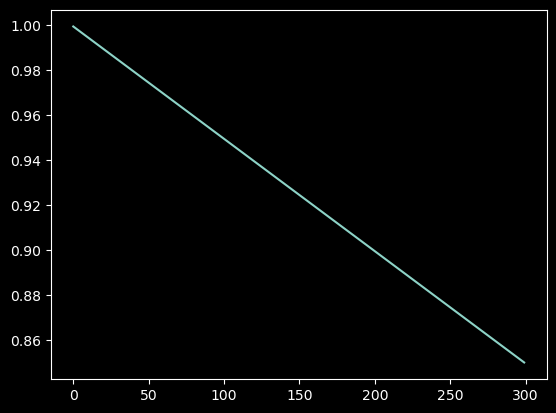

In [251]:
plt.plot(test_gwg_anneals)

In [227]:
print(init_obs_net_params["gamma"], init_outcome_params["eta"], init_outcome_params["sig_y"],
      init_true_net_params["theta"])

[-1.1304891  -1.1729406   0.04530792 -0.07929628] [ 2.9428563  3.0135105 -0.1721968  1.8051172] 0.6279472 [-2.220282    0.01391055  0.01751397]


mean acc rate:  0.99977785


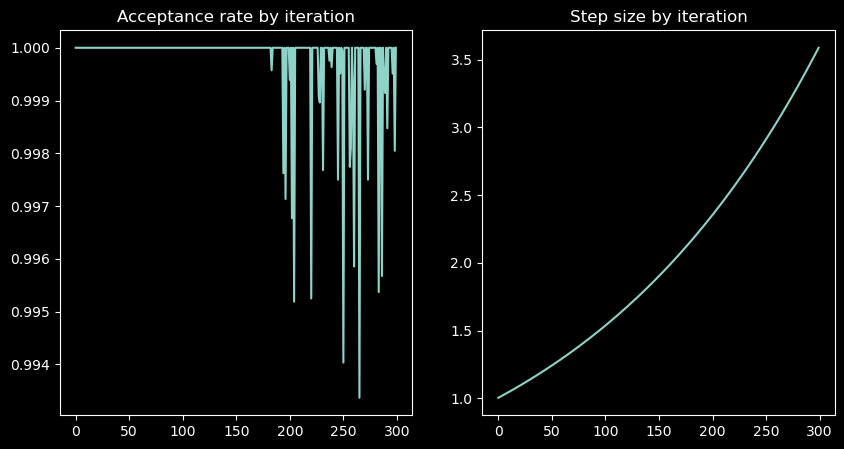

In [55]:
figs, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(test_gwg_acc, label="acceptance rate")
axs[0].set_title("Acceptance rate by iteration")

axs[1].plot(test_gwg_step, label="step size")
axs[1].set_title("Step size by iteration")

print("mean acc rate: ", jnp.mean(test_gwg_acc))

Text(0.5, 1.0, '-Log-posterior over iterations')

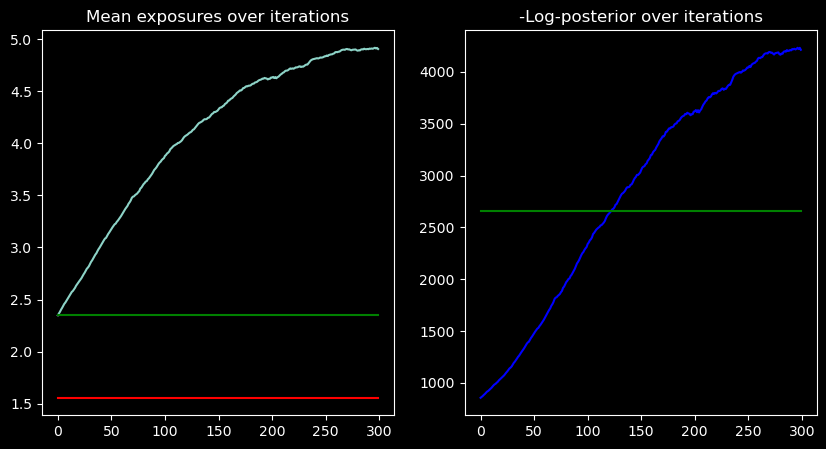

In [56]:
postgwg_expos = vmap_compute_exposures(test_gwg_state.positions, Z)
init_expos = compute_exposures(init_triu_star, Z)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))


# create line plot of expos_arr.mean(axis=1) (y axis) vs the index (x axis)
axs[0].plot(postgwg_expos.mean(axis=1))
axs[0].plot(jnp.ones(postgwg_expos.shape[0])*exposures.mean(), color='red')
axs[0].plot(jnp.ones(postgwg_expos.shape[0])*init_expos.mean(), color='green')
axs[0].set_title("Mean exposures over iterations")
# axs[0].xticks(range(0, 1500, 100), rotation=90)

axs[1].plot(-jnp.array(test_gwg_state.logdensity), color="blue")
axs[1].plot(-jnp.ones(len(test_gwg_state.logdensity))*init_states["triu_star"].logdensity, color="green")
# axs[1].plot(-jnp.ones(len(test_gwg_state.logdensity))*true_logpost, color="red")
axs[1].set_title("-Log-posterior over iterations")

In [167]:
gwg_step(key, final_carry[1], theta, gamma, eta, sig_y, 1.0)

(IPState(positions=Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), logdensity=Array(-97065.77, dtype=float32), logdensity_grad=Array([-3.146753 , -3.0533268, -3.283277 , ..., -3.6828635, -1.8605068,
        -2.3373919], dtype=float32), scores=Array([-1.5733765, -1.5266634, -1.6416385, ..., -1.8414317, -0.9302534,
        -1.1686959], dtype=float32)),
 IPInfo(acceptance_rate=Array(0.82953525, dtype=float32), is_accepted=Array(False, dtype=bool)))

In [58]:

def MWG_kernel(rng_key, states, step_sizes, n_mala_steps=10):
   # key_y, key_nets, key_triu_star = random.split(rng_key, 3)
   key_triu_star, key_mala = random.split(rng_key, 2)

    # copy states 
    # state_y = state_y.copy()
    # state_nets = state_nets.copy()
    # state_triu_star = state_triu_star.copy()
   states = states.copy()

    # --- update for triu_star ---
   states["triu_star"], info_triu_star = gwg_step(rng_key_=key_triu_star,
                                                   state_=states["triu_star"],
                                                #    theta_=states["nets"].position["theta"],
                                                   theta_=states["true_net"].position["theta"],
                                                    # gamma_= states["nets"].position["gamma"],
                                                    gamma_= states["obs_net"].position["gamma"],
                                                    eta_= states["Y"].position["eta"],
                                                    sig_y_= jnp.exp(states["Y"].position["sig_y"]),
                                                    step_size=step_sizes["triu_star"])


    # --- update for Y ---
    # conditional density (log posterior)
   def logdensity_fn_y(vals): return logdensity_Y(vals, states["triu_star"].positions)
   
   def logdensity_fn_true_net(vals): return logdensity_true_net(vals, states["triu_star"].positions)

   def logdensity_fn_obs_net(vals): return logdensity_obs_net(vals, states["triu_star"].positions)
    
   # Multiple MALA steps for continuous parameters
   mala_keys = random.split(key_mala, n_mala_steps * 3)  # 3 for Y, true_net, obs_net
   
   # Do n_mala_steps iterations but only keep final state/info
   for i in range(n_mala_steps):
      key_y, key_true, key_obs = mala_keys[i*3:(i+1)*3]
      # Update Y parameters
      states["Y"], info_y = mala_step_y(
         key_y, states["Y"], 
         logdensity_fn=logdensity_fn_y,
         step_size=step_sizes["Y"]
      )

      # Update true network parameters
      states["true_net"], info_true_net = mala_step_true_net(
         key_true, states["true_net"],
         logdensity_fn=logdensity_fn_true_net,
         step_size=step_sizes["true_net"]
      )

      # Update observed network parameters
      states["obs_net"], info_obs_net = mala_step_obs_net(
         key_obs, states["obs_net"],
         logdensity_fn=logdensity_fn_obs_net,
         step_size=step_sizes["obs_net"]
   )



   #  states["Y"], info_y = mala_step_y(key_y, states["Y"], logdensity_fn_y, step_sizes["Y"])
    # states["Y"] contain current 'eta' and 'sig_y' values
    # e.g., state["Y"].position["eta"] and state["Y"].position["sig_y"]

    # --- update for network ---
    # conditional density (log posterior)
    # def logdensity_fn_nets(vals): return logdensity_nets(vals, states["triu_star"].positions)

    # run mala step
    # states["nets"], info_nets = mala_step_nets(key_nets, states["nets"], logdensity_fn_nets, step_sizes["nets"])
    # states["networks"] contain current 'gamma' and 'theta' values
    # e.g., state["networks"].position["gamma"] and state["networks"].position["theta"]

    # --- update for true network ---
    # conditional density (log posterior)
   #  states["true_net"], info_true_net = mala_step_true_net(key_nets,
   #                                                          states["true_net"],
   #                                                          logdensity_fn_true_net,
   #                                                          step_sizes["true_net"])

   #  # --- update for observed network ---
   #  # conditional density (log posterior)
   #  states["obs_net"], info_obs_net = mala_step_obs_net(key_nets,
   #                                                      states["obs_net"],
   #                                                      logdensity_fn_obs_net,
   #                                                      step_sizes["obs_net"])


    # infos = {"Y": info_y, "nets": info_nets, "triu_star": info_triu_star}
   infos = {"Y": info_y,
            "true_net": info_true_net, 
            "obs_net": info_obs_net,
            "triu_star": info_triu_star}

   return states, infos

In [59]:
# triu_star_noisy = triu_obs
# triu_star_noisy = init_triu_star
(f_init,_), grad_init = val_grad_fn(init_triu_star,
                                    triu_obs,
                                    df_edges,
                                    init_true_net_params["theta"],
                                    init_obs_net_params["gamma"],
                                    Y, x, Z,
                                    init_outcome_params["eta"],
                                    init_outcome_params["sig_y"])
# (f_init,_), grad_init = val_grad_fn(triu_star_noisy,
#                                     triu_obs,
#                                     df_edges,
#                                     initial_position_net["theta"],
#                                     initial_position_net["gamma"],
#                                     Y, x, Z,
#                                     initial_position_oc["eta"],
#                                     jnp.exp(initial_position_oc["sig_y"]))

init_scores = (-(2*init_triu_star-1)*grad_init)/2

init_states = {
    "Y": mala_init_y(position=init_outcome_params,
                    logdensity_fn=lambda vals: logdensity_Y(vals, init_triu_star)),
    "true_net": mala_init_true_net(position=init_true_net_params,
                                    logdensity_fn=lambda vals: logdensity_true_net(vals,
                                                                                    init_triu_star)),
    "obs_net": mala_init_obs_net(position=init_obs_net_params,
                                logdensity_fn=lambda vals: logdensity_obs_net(vals,
                                                                            init_triu_star)),                                                                           
    "triu_star": IPState(init_triu_star, f_init, grad_init, init_scores)
}

init_step_sizes = {
    "Y": 1.0,
    # "nets": 1e-2,
    "true_net": 1.0,
    "obs_net": 1.0,
    "triu_star": 1.0
}

# init_states = {
#     "Y": mala_init_y(position=initial_position_oc,
#                     logdensity_fn=lambda vals: logdensity_Y(vals, final_carry[1].positions)),
#     "nets": mala_init_nets(position=initial_position_net,
#                                 logdensity_fn=lambda vals: logdensity_nets(vals, final_carry[1].positions)),
#     "triu_star": IPState(triu_star_noisy, f_init, grad_init, init_scores)
# }

# init_step_sizes = {
#     "Y": 1e-2,
#     "nets": 1e-2,
#     "triu_star": 1.0
# }

In [52]:
init_states

{'Y': MALAState(position={'eta': Array([ 2.5089529 ,  3.0265434 , -0.1680156 ,  0.49415922], dtype=float32), 'sig_y': Array(0.6249738, dtype=float32)}, logdensity=Array(-1033.5171, dtype=float32), logdensity_grad={'eta': Array([ 1.9087125e+00, -8.3566859e-02, -2.6845327e-04, -1.7500758e+00],      dtype=float32), 'sig_y': Array(0.9327665, dtype=float32)}),
 'true_net': MALAState(position={'theta': Array([-2.220282  ,  0.01391055,  0.01751397], dtype=float32)}, logdensity=Array(-40047.418, dtype=float32), logdensity_grad={'theta': Array([-176.0229 , -162.84769,  -25.00002], dtype=float32)}),
 'obs_net': MALAState(position={'gamma': Array([-1.1018633 , -1.170787  ,  0.03989992, -0.07628209], dtype=float32)}, logdensity=Array(-69125.22, dtype=float32), logdensity_grad={'gamma': Array([ 1.6736239e-04, -7.1583316e-03,  2.4838513e-04,  9.5057068e-05],      dtype=float32)}),
 'triu_star': IPState(positions=Array([0., 0., 0., ..., 0., 0., 0.], dtype=float32), logdensity=Array(-111157.26, dtype=

In [60]:


@jax.jit
def get_adapt_window(iteration, num_warmup):
    """Returns adaptation window size in a JAX-friendly way"""
    warmup_frac = iteration / num_warmup
    
    # Use linear logic instead of conditionals 
    window_sizes = jnp.array([1, 5, 20, 50])
    phase_cuts = jnp.array([0.15, 0.65, 0.9, 1.0])
    
    # Creates a boolean mask of which phase we're in
    phase_mask = warmup_frac <= phase_cuts
    
    # First True in mask indicates current phase
    phase_idx = jnp.argmax(phase_mask)
    
    return window_sizes[phase_idx]


In [64]:
%%time

class AdaptMWGState(NamedTuple):
    states: Any
    step_sizes: Any
    mean_acceptances: Any
    iteration: int

def mwg_loop(rng_key,
             kernel,
             init_states: dict,
             init_step_sizes: dict,
             num_samples: int,
            #  adapt_windows = {"Y": 10, "true_net": 10, "obs_net": 10, "triu_star": 10},
             target_acceptances = {"Y": 0.8, "true_net": 0.8, "obs_net": 0.8, "triu_star": 0.574},
             adaption_rates = {"Y": 0.1, "true_net": 0.1, "obs_net": 0.1, "triu_star": 0.01},
             num_warmup = 5000):
    
    def one_step(carry, key):
        adapt_state = carry
        
        window_size = get_adapt_window(adapt_state.iteration, num_warmup)
        # Run MWG step
        new_states, infos = kernel(key,
                                   adapt_state.states,
                                   adapt_state.step_sizes)
        
        # Update step sizes
        new_step_sizes = {} 
        # --- Y ---
        # should_adapt_Y = ((adapt_state.iteration + 1) % adapt_windows["Y"] == 0) & (adapt_state.iteration <= num_warmup)
        should_adapt_Y = ((adapt_state.iteration + 1) % window_size == 0) & (adapt_state.iteration <= num_warmup)
        new_step_sizes["Y"] = jnp.where(
            should_adapt_Y,
            adaptive_step_size_mala(adapt_state.step_sizes["Y"],
                                    infos["Y"].acceptance_rate,
                                    target_acceptances["Y"],
                                    adaption_rates["Y"]),
            adapt_state.step_sizes["Y"]
        )

        # --- networks ---
        # should_adapt_nets = ((adapt_state.iteration + 1) % adapt_windows["nets"] == 0) & (adapt_state.iteration <= num_warmup)
        # new_step_sizes["nets"] = jnp.where(
        #     should_adapt_nets,
        #     adaptive_step_size_mala(adapt_state.step_sizes["nets"],
        #                             infos["nets"].acceptance_rate,
        #                             target_acceptances["nets"],
        #                             adaption_rates["nets"]),
        #     adapt_state.step_sizes["nets"]
        # )

        # should_adapt_true_net = ((adapt_state.iteration + 1) % adapt_windows["true_net"] == 0) & (adapt_state.iteration <= num_warmup)
        should_adapt_true_net = ((adapt_state.iteration + 1) % window_size == 0) & (adapt_state.iteration <= num_warmup)
        new_step_sizes["true_net"] = jnp.where(
            should_adapt_true_net,
            adaptive_step_size_mala(adapt_state.step_sizes["true_net"],
                                    infos["true_net"].acceptance_rate,
                                    target_acceptances["true_net"],
                                    adaption_rates["true_net"]),
            adapt_state.step_sizes["true_net"]
        )

        # should_adapt_obs_net = ((adapt_state.iteration + 1) % adapt_windows["obs_net"] == 0) & (adapt_state.iteration <= num_warmup)
        should_adapt_obs_net = ((adapt_state.iteration + 1) % window_size == 0) & (adapt_state.iteration <= num_warmup)
        new_step_sizes["obs_net"] = jnp.where(
            should_adapt_obs_net,
            adaptive_step_size_mala(adapt_state.step_sizes["obs_net"],
                                    infos["obs_net"].acceptance_rate,
                                    target_acceptances["obs_net"],
                                    adaption_rates["obs_net"]),
            adapt_state.step_sizes["obs_net"]
        )

        # --- triu_star ---
        # should_adapt_triu_star = ((adapt_state.iteration + 1) % adapt_windows["triu_star"] == 0) & (adapt_state.iteration <= num_warmup)
        should_adapt_triu_star = ((adapt_state.iteration + 1) % window_size == 0) & (adapt_state.iteration <= num_warmup)
        new_step_sizes["triu_star"] = jnp.where(
            should_adapt_triu_star,
            adaptive_step_size(adapt_state.step_sizes["triu_star"],
                                infos["triu_star"].acceptance_rate,
                                target_acceptances["triu_star"],
                                adaption_rates["triu_star"]),
            adapt_state.step_sizes["triu_star"])
        # Update mean acceptance rates
        new_mean_accs = {}
        
        new_mean_accs["Y"] = adapt_state.mean_acceptances["Y"] + (
            infos["Y"].acceptance_rate - adapt_state.mean_acceptances["Y"]
        ) / (adapt_state.iteration + 1)

        # new_mean_accs["nets"] = adapt_state.mean_acceptances["nets"] + (
        #     infos["nets"].acceptance_rate - adapt_state.mean_acceptances["nets"]
        # ) / (adapt_state.iteration + 1)

        new_mean_accs["true_net"] = adapt_state.mean_acceptances["true_net"] + (
            infos["true_net"].acceptance_rate - adapt_state.mean_acceptances["true_net"]
        ) / (adapt_state.iteration + 1)

        new_mean_accs["obs_net"] = adapt_state.mean_acceptances["obs_net"] + (
            infos["obs_net"].acceptance_rate - adapt_state.mean_acceptances["obs_net"]
        ) / (adapt_state.iteration + 1)



        new_mean_accs["triu_star"] = adapt_state.mean_acceptances["triu_star"] + (
            infos["triu_star"].acceptance_rate - adapt_state.mean_acceptances["triu_star"]
        ) / (adapt_state.iteration + 1)


        new_adapt_state = AdaptMWGState(
            states=new_states,
            step_sizes=new_step_sizes,
            mean_acceptances=new_mean_accs,
            iteration=adapt_state.iteration + 1
        )

        return new_adapt_state, (new_states, infos, new_step_sizes)

    keys = random.split(rng_key, num_samples + num_warmup)
    init_adapt_state = AdaptMWGState(
        states=init_states,
        step_sizes=init_step_sizes,
        # mean_acceptances={"Y": 0.0, "nets": 0.0, "triu_star": 0.0},
        mean_acceptances={"Y": 0.0, "true_net": 0.0, "obs_net": 0.0, "triu_star": 0.0},
        iteration=0
    )

    _, (final_states, infos, final_step_sizes) = jax.lax.scan(one_step, init_adapt_state, keys)

    return final_states, infos, final_step_sizes

sample_key, warmup_key = random.split(warmup_key)


TRIU_LEN = triu_star.shape[0]
BATCH_PROP = .0005
BATCH_LEN = int(TRIU_LEN * BATCH_PROP)
# BATCH_LEN = 500
# BATCH_LEN = 5
# BATCH_LEN = 2*jnp.ceil(jnp.log(n)).astype(int)
# BATCH_LEN = 4*jnp.ceil(jnp.log(TRIU_LEN)).astype(int)
# BATCH_LEN = jnp.ceil(jnp.log(TRIU_LEN)/2).astype(int)
print(BATCH_LEN)

# final_states, infos, final_step_sizes = mwg_loop(
#     sample_key,
#     MWG_kernel,
#     init_states,
#     init_step_sizes,
#     num_samples=3000,
#     # target_acceptances={"Y": 0.8, "nets": 0.8, "triu_star": 0.574},
#     target_acceptances={"Y": 0.574, "true_net": 0.574, "obs_net": 0.574, "triu_star": 0.574},
#     # adaption_rates={"Y": 0.05, "nets": 0.05, "triu_star": 0.01},
#     adaption_rates={"Y": 0.05, "true_net": 0.05, "obs_net": 0.05, "triu_star": 0.05},
#     num_warmup=5000
# )



62
CPU times: total: 31.2 ms
Wall time: 1.2 ms


In [318]:
n_warmup = 5000
print("Y:", infos["Y"].acceptance_rate[n_warmup:].mean(), final_step_sizes["Y"][-1])
# print("Nets:", infos["nets"].acceptance_rate[n_warmup:].mean(), final_step_sizes["nets"][-1])
print("true_net (theta):", infos["true_net"].acceptance_rate[n_warmup:].mean(), final_step_sizes["true_net"][-1])
print("obs_net (gamma):", infos["obs_net"].acceptance_rate[n_warmup:].mean(), final_step_sizes["obs_net"][-1])
print("Triu_star:", infos["triu_star"].acceptance_rate[n_warmup:].mean(), final_step_sizes["triu_star"][-1])

Y: 0.6192101 0.0011090577
true_net (theta): 1.6889169e-17 6.4801056e-14
obs_net (gamma): 0.5557112 3.315735e-05
Triu_star: 0.347785 2.1446247e-05


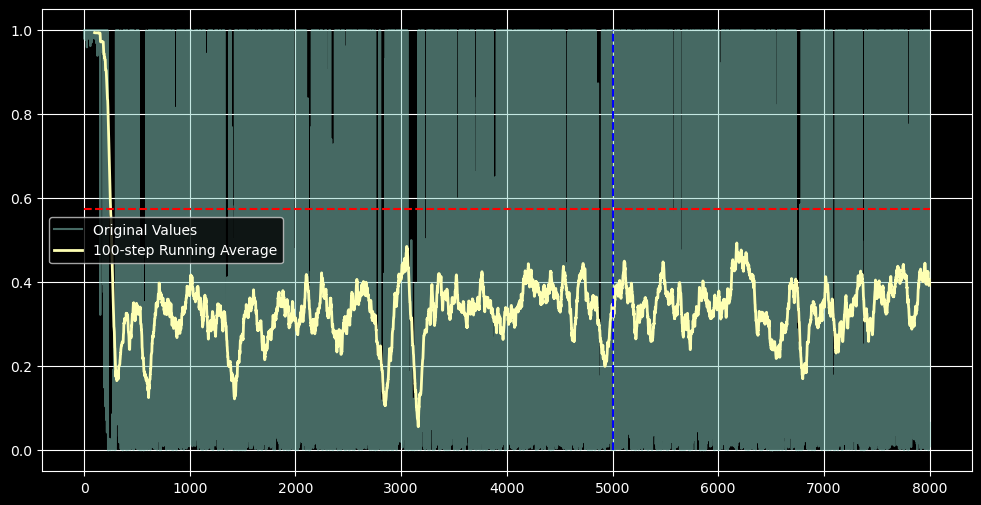

In [319]:
plot_running_average(infos["triu_star"].acceptance_rate, num_warmpup=n_warmup, target_rate=0.574)

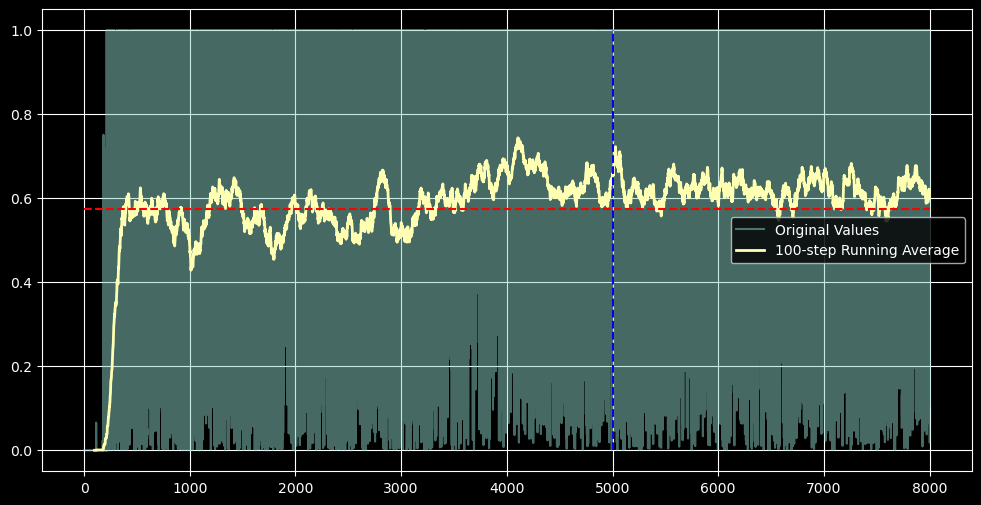

In [320]:
plot_running_average(infos["Y"].acceptance_rate, num_warmpup=n_warmup, target_rate=0.574)

In [321]:
print("true gamma: ", gamma, "\n",
      "true eta: ", eta, "\n",
      "true theta: ", theta)

post_y = {"eta" : final_states["Y"].position["eta"][n_warmup:,][None, ...],
            "sig_y" : jnp.exp(final_states["Y"].position["sig_y"][n_warmup:,][None, ...]),}

post_nets = {"gamma" : final_states["obs_net"].position["gamma"][n_warmup:,][None, ...],
            "theta" : final_states["true_net"].position["theta"][n_warmup:,][None, ...],}

idata_y = az.from_dict(posterior=post_y)
idata_nets = az.from_dict(posterior=post_nets)

print("init outcome", init_outcome_params)
az.summary(idata_y)

true gamma:  [ 0.84729785 -1.3862944   0.1        -0.5       ] 
 true eta:  [-1.    3.   -0.25  3.  ] 
 true theta:  [-2.5  -0.25  1.  ]


arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


init outcome {'eta': Array([ 3.7183380e+00,  2.9695477e+00, -1.7250709e-01, -3.4233290e-03],      dtype=float32), 'sig_y': Array(0.6256026, dtype=float32)}


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta[0],3.777,0.481,2.914,4.649,0.171,0.131,9.0,19.0,NaN
eta[1],2.965,0.179,2.608,3.284,0.010,0.007,298.0,543.0,NaN
eta[2],-0.170,0.089,-0.327,0.008,0.002,0.002,1335.0,2023.0,NaN
eta[3],-0.029,0.201,-0.419,0.318,0.076,0.056,8.0,18.0,NaN
sig_y,1.882,0.060,1.776,2.001,0.001,0.001,2809.0,2550.0,NaN


In [322]:
print("init theta", init_true_net_params)
print("true theta", theta)
print("init gamma", init_obs_net_params)
print("true gamma", gamma)
az.summary(idata_nets)

arviz - WARNING - Shape validation failed: input_shape: (1, 3000), minimum_shape: (chains=2, draws=4)


init theta {'theta': Array([-2.1852627 , -0.00800541, -0.01391113], dtype=float32)}
true theta [-2.5  -0.25  1.  ]
init gamma {'gamma': Array([-1.1112335 , -1.1708179 ,  0.04203812, -0.08386104], dtype=float32)}
true gamma [ 0.84729785 -1.3862944   0.1        -0.5       ]


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],-1.161,0.025,-1.207,-1.116,0.012,0.010,4.0,26.0,NaN
gamma[1],-1.167,0.012,-1.191,-1.144,0.001,0.001,193.0,1819.0,NaN
gamma[2],0.045,0.009,0.028,0.061,0.001,0.000,230.0,2294.0,NaN
gamma[3],-0.088,0.019,-0.124,-0.054,0.001,0.001,171.0,785.0,NaN
theta[0],-2.163,0.000,-2.163,-2.163,0.000,0.000,3000.0,3000.0,NaN
theta[1],-0.027,0.000,-0.027,-0.027,0.000,0.000,3000.0,3000.0,NaN
theta[2],-0.039,0.000,-0.039,-0.039,0.000,0.000,3000.0,3000.0,NaN


In [323]:
exposures_post = vmap_compute_exposures(final_states["triu_star"].positions, Z)
print(exposures_post.shape)


(8000, 500)


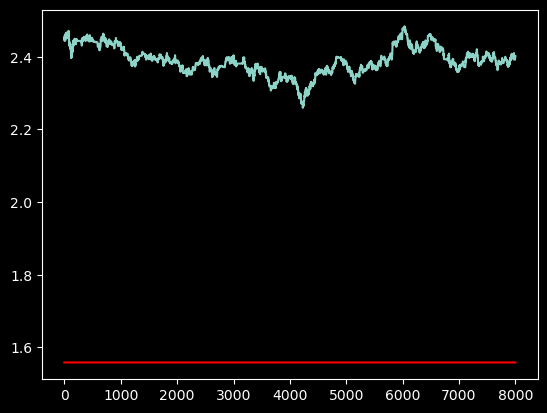

In [324]:
plt.plot(exposures_post.mean(axis=1))
plt.plot(jnp.ones(exposures_post.shape[0])*exposures.mean(), color='red')
# plt.plot(jnp.ones(exposures_post.shape[0])*expos_obs.mean(), color='green')

In [31]:
# Continuous relaxation with Gumbel-softmax

from numpyro.infer import MCMC, NUTS

# temp = .1


def combined_model(triu_obs, df_edges, X, Z, Y=None):
    # True network model (given triu_star value)
    # priors
    with numpyro.plate("theta_plate", df_edges.shape[1]):
        theta = numpyro.sample("theta", dist.Normal(0, 5))

    # likelihood

    temp = numpyro.sample("temp", dist.Exponential(2.0))
    # star_logits = jnp.dot(df_edges, theta)
    star_logits = df_edges @ theta
    # numpyro.sample("triu_star", dist.Bernoulli(logits=star_logits), obs=triu_star)
    # with numpyro.plate("triu_star_plate", triu_obs.shape[0]):
    #     triu_star =  numpyro.sample("triu_star", dist.RelaxedBernoulliLogits(temperature=temp,
    #                                                         logits=star_logits))
    triu_star = numpyro.sample("triu_star", dist.RelaxedBernoulliLogits(temperature=temp,
                                                        logits=star_logits))

    # Outcome model
    expos = compute_exposures(triu_star, Z)
    df_nodes = jnp.transpose(jnp.stack([jnp.ones(n), Z, X, expos]))

    # priors
    with numpyro.plate("eta_plate", df_nodes.shape[1]):
        eta = numpyro.sample("eta", dist.Normal(0, 5))
    
    # log_sig_y = numpyro.sample("log_sig_y", dist.Normal(0, 1))
    # sig_y = numpyro.sample("sig_y", dist.LogNormal(scale=1.0))
    sig_y = numpyro.sample("sig_y", dist.HalfNormal(2.0))
    # likelihood
    # mean_y = jnp.dot(df_nodes, eta)
    mean_y = df_nodes @ eta
    # numpyro.sample("Y", dist.Normal(mean_y, jnp.exp(log_sig_y)), obs=Y)
    numpyro.sample("Y", dist.Normal(mean_y, sig_y), obs=Y)
    
    
    # Proxy nets model
    # priors
    with numpyro.plate("gamma_plate", 1 + df_edges.shape[1]):
        gamma = numpyro.sample("gamma", dist.Normal(0, 5))
    
    # likelihood
    # obs_logits = triu_star*gamma[0] + (1 - triu_star)*gamma[1]
    obs_logits = triu_star*gamma[0] + (1 - triu_star)* (df_edges @ gamma[1:])
    # obs_logits = jnp.where(triu_star == 1, gamma[0], gamma[1])
    numpyro.sample("triu_obs", dist.Bernoulli(logits=obs_logits), obs=triu_obs)


# Run NUTS 

# kernel_combined = NUTS(combined_model)
# mcmc_comb = MCMC(kernel_combined, num_warmup=1000, num_samples=1000, 
#                  num_chains=4, chain_method='parallel', progress_bar=True)
# mcmc_comb.run(rng_key, triu_obs, df_edges, x, Z, Y)
# mcmc_comb.print_summary()




In [32]:
from numpyro.infer import SVI, Trace_ELBO
import numpyro.optim as optim
from numpyro.infer.autoguide import AutoNormal



comb_model_guide = AutoNormal(combined_model)

optimz = optim.Adam(0.01)

comb_svi = SVI(model=combined_model,
               guide=comb_model_guide, 
               optim=optimz,
                loss=Trace_ELBO())

n_steps = 5000
rng_key,_ = random.split(rng_key)

comb_net_res = comb_svi.run(rng_key, n_steps, triu_obs, df_edges, x, Z, Y)

print(comb_net_res.params)



100%|██████████| 5000/5000 [01:36<00:00, 51.88it/s, init loss: 681781.3750, avg. loss [4751-5000]: 71971.0792]


{'eta_auto_loc': Array([-2.1466284 ,  2.7775083 , -0.2016478 ,  0.18769339], dtype=float32), 'eta_auto_scale': Array([0.07143129, 0.09050046, 0.06195507, 0.02229762], dtype=float32), 'gamma_auto_loc': Array([-0.65164214, -1.5021629 ,  0.12747602, -0.3386808 ], dtype=float32), 'gamma_auto_scale': Array([0.01626669, 0.01159901, 0.00859814, 0.03144655], dtype=float32), 'sig_y_auto_loc': Array(0.41746455, dtype=float32), 'sig_y_auto_scale': Array(0.06956454, dtype=float32), 'temp_auto_loc': Array(0.7445963, dtype=float32), 'temp_auto_scale': Array(0.00336309, dtype=float32), 'theta_auto_loc': Array([-0.98292285, -0.5849256 ,  1.2760969 ], dtype=float32), 'theta_auto_scale': Array([0.01071166, 0.00893289, 0.01188092], dtype=float32), 'triu_star_auto_loc': Array([-0.6052675 , -0.47079593, -0.7281943 , ..., -1.0376443 ,
        0.12424444, -0.427903  ], dtype=float32), 'triu_star_auto_scale': Array([0.8011414 , 0.82328224, 0.8321538 , ..., 0.7955652 , 0.80564773,
       0.8453822 ], dtype=flo

In [44]:
from numpyro.infer import Predictive

# First, get samples from the guide (variational distribution)
guide_samples = Predictive(comb_model_guide, params=comb_net_res.params, num_samples =1000)(
    random.PRNGKey(0)
)

# Then, if you want posterior predictive samples, you can do:
posterior_predictive = Predictive(combined_model, guide_samples)(
    random.PRNGKey(1),
    triu_obs, df_edges, x, Z)

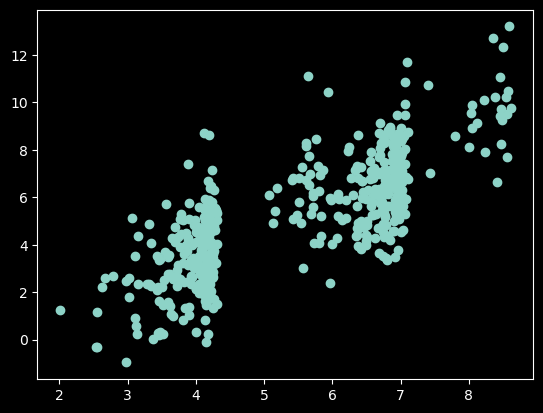

In [45]:
plt.scatter(posterior_predictive["Y"].mean(axis=0), Y)

cor exposures:  [[1.         0.71603507]
 [0.71603507 1.        ]] mean expos (Std):  32.834526 3.1666794


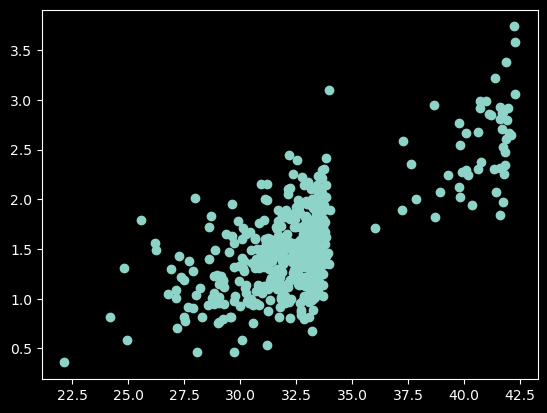

In [55]:

vmap_compute_exposures = jax.vmap(compute_exposures, in_axes=(0, None))
post_expos = vmap_compute_exposures(guide_samples["triu_star"], Z)

plt.scatter(post_expos.mean(axis=0), exposures)
print("cor exposures: ", np.corrcoef(post_expos.mean(axis=0), exposures),
      "mean expos (Std): ", np.mean(post_expos.mean(axis=0)), np.std(post_expos.mean(axis=0)),)

cor exposures:  [[1.         0.51229635]
 [0.51229635 1.        ]] 
 cor degrees:  [[1.         0.78477277]
 [0.78477277 1.        ]]


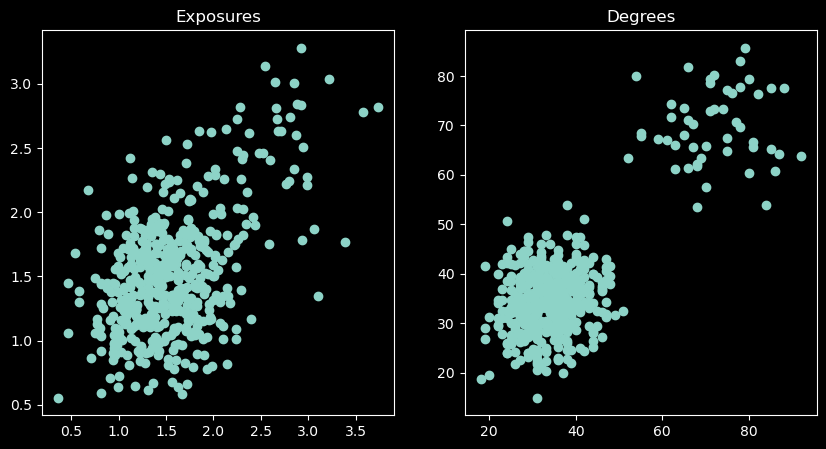

In [28]:
# test realxation by sample

relax_triu_star = dist.RelaxedBernoulliLogits(temperature=0.1,
                                                logits=jnp.dot(df_edges, theta)).sample(random.PRNGKey(0))


relax_expos = compute_exposures(relax_triu_star, Z)
relax_deg = jnp.sum(aux.Triu_to_mat(relax_triu_star), axis=1)
true_deg = jnp.sum(aux.Triu_to_mat(triu_star), axis=1)


figs, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].scatter(exposures, relax_expos)
axs[0].set_title("Exposures")

axs[1].scatter(true_deg, relax_deg)
axs[1].set_title("Degrees")

print("cor exposures: ", np.corrcoef(exposures, relax_expos), "\n",
      "cor degrees: ", np.corrcoef(true_deg, relax_deg))

In [ ]:
# https://blackjax-devs.github.io/blackjax/examples/howto_metropolis_within_gibbs.html
# TODO: think about initialisation startegies for latent variables (e.g. triu_star) in the model 
# TODO: probably should stick to GWG kernel and not DMALA for A* updates. 
# TODO: think about number of edges to update per iteration.


# TODO: think about initalization for all parameter
#        One option is to use optimzation to find the MAP estimate of the parameters
#       Here we maybe can use 'triu_obs' as init of 'triu_star' and then get MAP for each model.

# TODO: maybe perform number of MALA updates for each 'triu_star' update?


# TODO: Parallel code that run multiple chain of MWG in parallel --> 
#       use pmap with different init values for triu_star (?)

# TODO: Finally, wrap everything in seperate scripts and classes

# TODO: keep tinkering with different init and convergence techniques
#        currently stuck in some local place and not moving much

# TODO: maybe the issue is with MALA! it have slow steps and often stuck in local position
#           Can change to HMC (no NUTS due to adaptive natur), ESS or other continuous algo
#   Maybe SMC (sequential monte carlo) can help? read https://arxiv.org/pdf/2007.11936
#  Maybe Block-MWG, namely, block of continous given A* and block of A* given continuous (e.g., 1000 iter each)

# TODO: keep thinking about the annelaing setup (either logdensity or RW kernel)

# TODO: Sequential Monte Carlo (SMC) for the rescue? CONSIDER IT!

# TODO: Augmented variables $U = h(X, \theta)$ i.e., $U \ sim N(X\theta, \sigma)$ independent 
#       and $A*_{ij} = I(U_{ij} > 0)$
